#Identifying early Dementia with MRI scans
##A project for the Data science seminer
##names:
Asaph Cohen - 305572661  
Yehuda Klein - 315215889
##Introduction
Dementia can be a very difficult ilness to deal with and as with many other ilnisses, early detection can often be key to dealing with it properly.

To this end we want to build a cassifier to assist with detecting early signs of demetia.

In the project we are using a database of MRI brain scans, together with the level of dementia of the patient.  
We want to use this database to build and test several ideas for calssifiers that recive an MRI scan and output the level of dementia.

We test and compare four types of classifers
1. We analize the photos with classical methods (...) and create a classifier based on them.
2. a classic CNN - inputs a photo and outputs a class
3. a combined idea - train an autoencoder on the photos. Use the encoder for dimension reduction, and then use classical classifiers (such as a logistic regression) on the result.
4. using an autoencoder that outputs the class (i.e. demetia status) as well as the photo. The idea is to direct its learning to the features more relevant for the classification.

Overall, we are hoping to achieve 2 goals:  
Firstly, we want to build a dependable classifier for detecting dementia levels. With brain deseases in general, and dementia in particular, early detection is the key factor in preventing permanent damage, and any automation for detecting signs of brain failure can help minimize the effects of alzheimers, strokes, parkinson's and so on.  

Secondly, we want to test different approaches to create a classifier in order to better understand what approach would work under our circumstances. Our data is intersting in the sense that it is constructed from simple building blocks (a small range of pixel values from dark to bright), but it creates complicated structures.


database: [Kaggle link](https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset)  

##project flow:
1. reading the data and preproccesing
2. prelimanery examination
3. analizing the photos and building a classic clasifier
3. CNN
4. First autoencoder - preparing data and training
5. running encoder on sample images for dimention reduction
6. building a logistic regression classifier
7. analizing the autoencoder - examing how variation in encoded values effect the decoded image
8. Second Autoencoder - with bias towards encoding dementia related features
9. repeating steps 5-7 for the new autoencoder


##About the dataset:  
We have two collections of MRI photos:  
  1. The original dataset, which is a collection of MRI scans from patients with varying levels of dementia. This dataset is relatively small, and VERY unbalanced in sample size per class.
  2. The augmented dataset. The dataset author URANINJO generated synthetic MRI scans, and the result is a much more class-wise balanced 'scans' collections.
  
Each of the collections has 4 target classes of increasingly damaged brains:  
  1. Non-Demented - MRI scans of a healthy brain.
  2. Very-Mild-Demented.
  3. Mild-Demented.
  4. Moderate-demented - The most damaged brain-class.

The original dataset consists of 6400 images. However, practically it is much smaller because there are only 64 images in the Moderate-demented class, and only 896 images in the Mild-Demented class. 85% of the data is in the classes with little to no brain damage.  
  
Hence, our general course of action will be:  
  1. Train a model on the augmented data
  2. Attempt to use the model to classify the original data
  




#preprocessing section

##Setting up

We did most of our work in google colab, and here we have a bit of environment setup code - the imports, the file navigation etc...

In [ ]:
!pip install shap
import shap

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import sklearn
import sklearn.model_selection
import random
from sklearn.linear_model import LogisticRegression
import plotly.express as px
import seaborn as sns
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import data, exposure

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#note: this might be required to change - depending on where its run from
%cd drive/MyDrive/data_science_project/AugmentedAlzheimerDataset

/content/drive/.shortcut-targets-by-id/1lc6Zd5i_ExA-gwrTE6KKpPFiUVL8be5x/data_science_project/AugmentedAlzheimerDataset


In [ ]:
#one of those two should run
%cd drive/MyDrive/GitHub/data_science_project/AugmentedAlzheimerDataset

/content/drive/MyDrive/GitHub/data_science_project/AugmentedAlzheimerDataset


##image example:  
Before doing anything, we want to see what exactly is the type of image we are working with. Here we have an example from the augmented dataset.

In [ ]:
dir = 'MildDemented'
file_list = os.listdir(dir)
image = cv2.imread(dir + '/' + file_list[10])

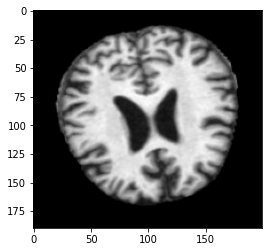

In [ ]:
plt.imshow(image)

#Reading the data  

##A little bit about data processing  
When we first began handling the image, one very large problem that made itself immediatly obvious was - we can't really load the data to memory. The loading process took about half an hour on average, depending on the amount and type of data being loaded. Because we are working in an online environment, the computing session often crashes and all the data in memory is lost and needs to be reloaded. The problem was eventually solved by saving the data in array format as opposed to collections of jpg files. Our assumption is that the image files were stored in cloud fashion, meaning they were spread across various servers which are not necesseraly geographically close, and that loading them as separate files involved unreasonable amounts of internet traffic.
So instead of loading a folder of jpg files, we now use '.npy' format files of arrays where the rows (0 axis entries) are different images.  
The data is also non-uniform in size, which makes handling much more difficult. We settled on a normalized value for the side of an image of 228 pixels.

Technical note: most of the code dealing with reading or writing large amounts of image data or DNN training we consider sensitive, as it could lead to overwriting files that require large amounts of computation resources to produce. When encountering a commented-out section of code in this project, it is a snippet that we recommend not running - it will take a long time, will probably crash and will overwrite allready computed files, possibly diffrently if the computation is non-deterministic (such as training a network).

This is the general method of normalizing the sizes of the MRIs. This function eats our images one by one and returns the processed image to whatever collection we are trying to generate.

In [ ]:
IMG_NORMAL_SIZE = 228

def normalizeSide(image):
  rows = image.shape[0]
  cols = image.shape[1]
  top = (IMG_NORMAL_SIZE - rows) // 2
  bottom = IMG_NORMAL_SIZE - rows - top
  left = (IMG_NORMAL_SIZE - cols) // 2
  right = IMG_NORMAL_SIZE - cols - left

  image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT)
  return image


In [ ]:
# for i, dir in enumerate(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']):
#   images = []
#   print(f'loading {i+1}/4')
#   con_dir = os.listdir(dir)
#   for j,file in enumerate(con_dir):
#     image = normalizeSide(cv2.imread(dir + '/' + file, cv2.IMREAD_GRAYSCALE))
#     images.append(image)
#     if j % 100 == 0:
#       print(f'{int(j/len(con_dir)*100)}%')
#   np.save(dir + '_augmented_normalized', np.array(images))
  

# EDA  

In this section we try to take a better look at the data we have, and understand the major components. We have 2 distinct datasets - the original and the augmented. We will try to explore both of them in parallel, with the hopes that we will not find many differences.

In [ ]:
original_non_imgs = np.load("../NormedOriginalDataByTypes/NonDemented.npy")
original_vmild_imgs = np.load("../NormedOriginalDataByTypes/VeryMildDemented.npy")
original_mild_imgs = np.load("../NormedOriginalDataByTypes/MildDemented.npy")
original_moder_imgs = np.load("../NormedOriginalDataByTypes/ModerateDemented.npy")

augmented_non_imgs = np.load("NonDemented_augmented_normalized.npy")
augmented_vmild_imgs = np.load("VeryMildDemented_augmented_normalized.npy")
augmented_mild_imgs = np.load("MildDemented_augmented_normalized.npy")
augmented_moder_imgs = np.load("ModerateDemented_augmented_normalized.npy")

### About brain MRI scans
When a doctor is trying to identify dementia in a patient's MRI, he would have a full 3D MRI scan of the 3 scan planes:
1. Axial: The scan from top to bottom.
2. Sagittal: The scan from left to right.
3. Coronal: From back to front.  

We have 2D images, and these are only from the axial plane. These images are also from different depths, as can be seen in the next example.

Text(0.5, 1.0, 'Low axial MRI')

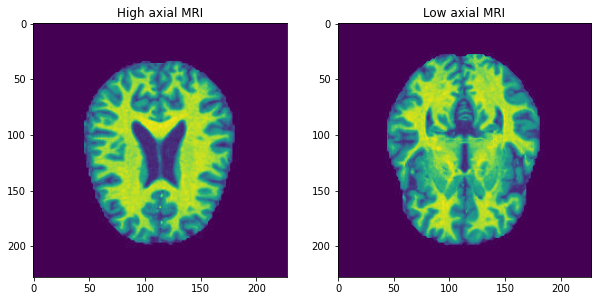

In [ ]:
fig = plt.figure(figsize = (10,10))
axs = fig.subplots(1,2)
axs[0].imshow(original_non_imgs[0])
axs[0].set_title('High axial MRI')
axs[1].imshow(original_non_imgs[64])
axs[1].set_title('Low axial MRI')

As we can see, the depth of the scan position changes the structure of the image greatly.

In order to estimate the diffrences in positional distribution between our target classes, we created mean images for each class, attempting to catch large structural differences.  
The upper row holds the means of the original data, and the lower the ones of the augmented:

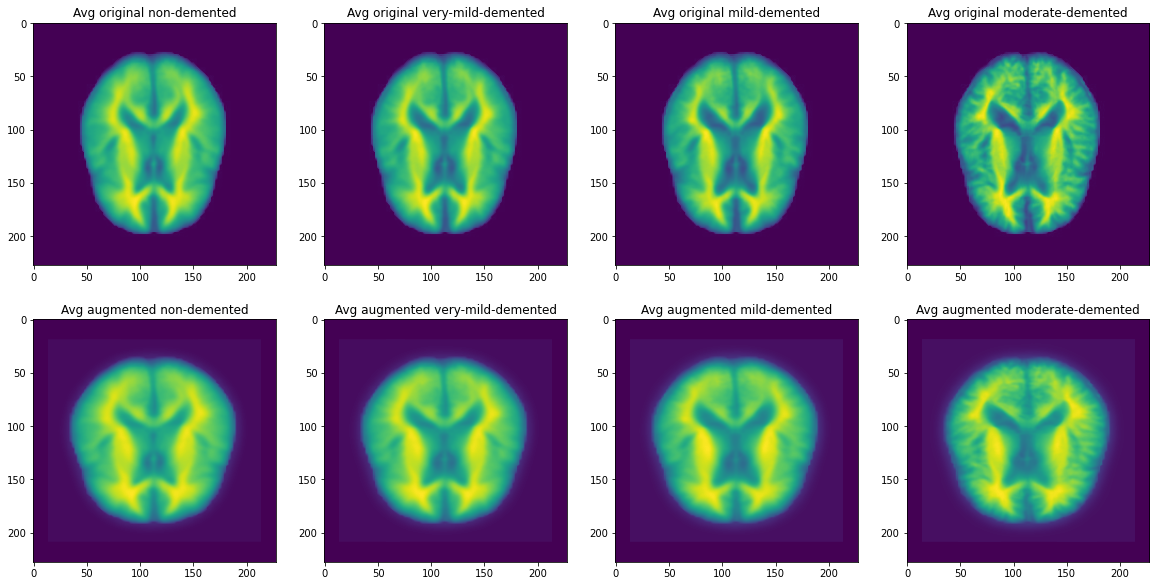

In [ ]:
avg_ori_non_demented = np.sum(original_non_imgs, axis=0) / len(original_non_imgs)
avg_ori_vmild_demented = np.sum(original_vmild_imgs, axis=0) / len(original_vmild_imgs)
avg_ori_mild_demented = np.sum(original_mild_imgs, axis=0) / len(original_mild_imgs)
avg_ori_moderate_demented = np.sum(original_moder_imgs, axis=0) / len(original_moder_imgs)

avg_aug_non_demented = np.sum(augmented_non_imgs, axis=0) / len(augmented_non_imgs)
avg_aug_vmild_demented = np.sum(augmented_vmild_imgs, axis=0) / len(augmented_vmild_imgs)
avg_aug_mild_demented = np.sum(augmented_mild_imgs, axis=0) / len(augmented_mild_imgs)
avg_aug_moderate_demented = np.sum(augmented_moder_imgs, axis=0) / len(augmented_moder_imgs)

means_fig = plt.figure(figsize = (20,10))
axs = means_fig.subplots(2,4)
axs[0][0].set_title('Avg original non-demented')
axs[0][0].imshow(avg_ori_non_demented)
axs[0][1].set_title('Avg original very-mild-demented')
axs[0][1].imshow(avg_ori_vmild_demented)
axs[0][2].set_title('Avg original mild-demented')
axs[0][2].imshow(avg_ori_mild_demented)
axs[0][3].set_title('Avg original moderate-demented')
axs[0][3].imshow(avg_ori_moderate_demented)
axs[1][0].set_title('Avg augmented non-demented')
axs[1][0].imshow(avg_aug_non_demented)
axs[1][1].set_title('Avg augmented very-mild-demented')
axs[1][1].imshow(avg_aug_vmild_demented)
axs[1][2].set_title('Avg augmented mild-demented')
axs[1][2].imshow(avg_aug_mild_demented)
axs[1][3].set_title('Avg augmented moderate-demented')
axs[1][3].imshow(avg_aug_moderate_demented)

The results above show that overall, the differences of the MRI positions we have are not very large between the classes. The means look pretty much the same between the different dementia classes, excepting a variation on the amount of blur.  
The second thing we notice, is that the augmented data is rounder than the original - it almost looks like a vertically compressed version of the same image.  
However, the difference in blur is quite interesting. Firstly, we will analyze the top row - the originals.  
We can see that the further we progress across dementia severity, we get a sharper image. That is to be expected, because we have less image files the more severe the dementia class is.  
This leads to another important characteristic of an MRI scan - differentiating between gray matter and white matter.

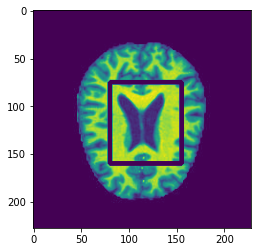

In [ ]:
example = copy.copy(original_non_imgs[0])
cv2.rectangle(example, (80,75), (155,160), color=(0,0,255), thickness=3)
plt.imshow(example)

The above image has the two components separated with a rectangle shape. Outside the rectangle we have the gray matter, inside the white matter.  We can easily see the differences in structural complexity. the white matter is mostly uniform, with some hollowness in the middle that depends on the position of the scan as we saw above. The gray matter on the other hand is 'spaghetti shaped' - it contains many smaller features.  
Modern neurology believes that the most of the higher level thinking capalities that humans show are in fact computed in the gray matter. As a consequence, when trying to find dementia signs, neurologists tend to look for decaying in the gray matter - like we show in the next example:

Text(0.5, 1.0, 'Demented')

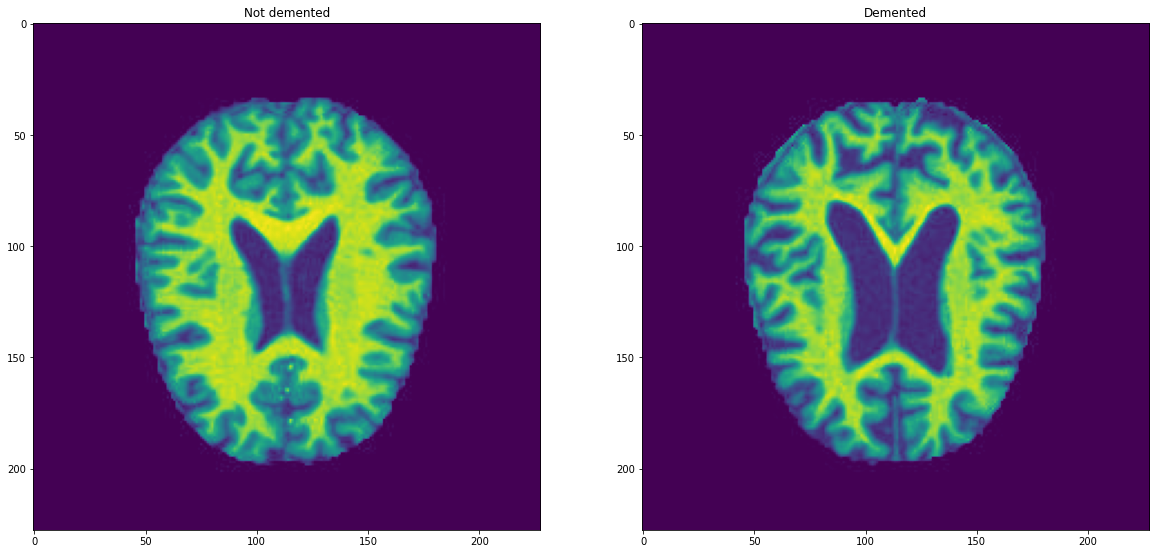

In [ ]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(1,2)
axs[0].imshow(original_non_imgs[0])
axs[0].set_title('Not demented')
axs[1].imshow(original_moder_imgs[0])
axs[1].set_title('Demented')

It may not be immediatly obvious, but once you notice it for the first time the differences become easy to spot - these 'antenna' we see in the demented image have much longer gaps between them with comparison to a healthy brain. Many of the neurons that used to occupy that area have died - hence the dementia.

Returning to the mean images, we can see that the blurring we see is mostly positioned in the gray matter region:

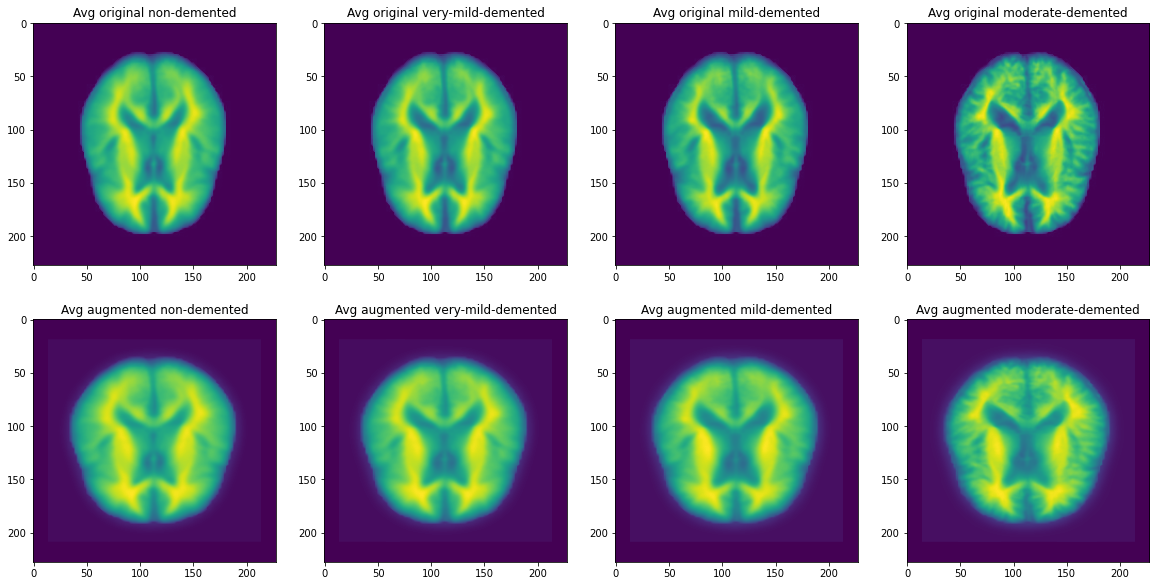

In [ ]:
means_fig

We can see that the augmented data has a similar characteristic to the originals. The lighter the dementia, the blurrier the image. However - here we cannot blame the amount of data - all the classes in the augmented dataset have more images in them that the largest class in the original data (NonDemented class). There could be two explanations for this result:  
1. The augmented data was not augmented very well, and many of the images are identical.
2. The augmented data holds much less high intensity values in the gray matter region, and therefore the high values are less uniform across the image, and we get sharper results.

In order to test the augmented data we have a comparison of random images in the moderate class - where most of the augmentation took place.

In [ ]:
identical_pair_count = 0
not_identical_pair_count = 0
for i in range(50):
  r = random.sample(range(len(augmented_moder_imgs)),2)
  if np.array_equal(augmented_moder_imgs[r[0]], augmented_moder_imgs[r[1]]):
    identical_pair_count += 1
  else:
    not_identical_pair_count += 1

print(f'identical pairs: {identical_pair_count}')
print(f'not identical pairs: {not_identical_pair_count}')

identical pairs: 0
not identical pairs: 50


And since there do not seem to be any identical pairs, we can assume explanation 2 - the lesser blurring is a result of less gray matter.

With this in mind, we would like to measure the total image intenseties of the different classes, i.e. the average intensity per pixel. For that, we just devide the previous means by the image resolution.

Text(0.5, 1.0, 'Augmented')

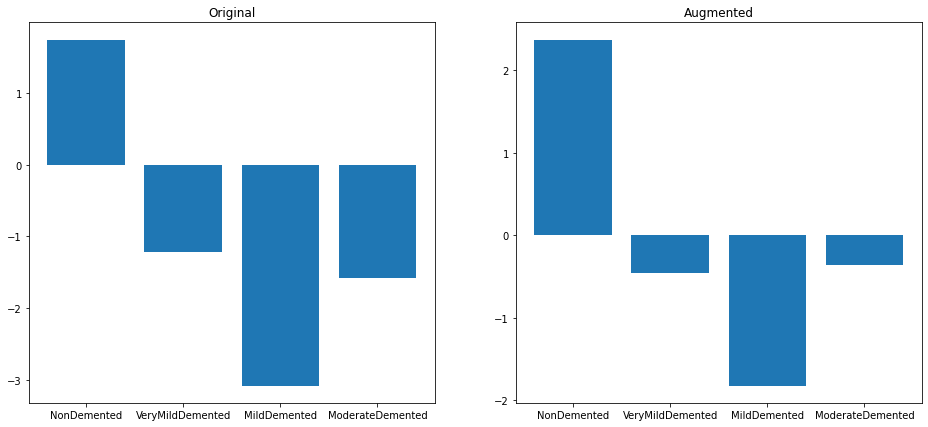

In [ ]:
org_sums = [np.sum(avg_ori_non_demented), np.sum(avg_ori_vmild_demented), np.sum(avg_ori_mild_demented), np.sum(avg_ori_moderate_demented)]
org_count = [original_non_imgs.shape[0], original_vmild_imgs.shape[0],original_mild_imgs.shape[0],original_moder_imgs.shape[0]]
org_total = sum(org_count)
aug_sums = [np.sum(avg_aug_non_demented), np.sum(avg_aug_vmild_demented), np.sum(avg_aug_mild_demented), np.sum(avg_aug_moderate_demented)]
aug_count = [augmented_non_imgs.shape[0], augmented_vmild_imgs.shape[0], augmented_mild_imgs.shape[0],augmented_moder_imgs.shape[0]]
aug_total = sum(aug_count)
original_mean_intenseties = [x / (IMG_NORMAL_SIZE ** 2) for x in org_sums]
augmented_mean_intenseties = [x / (IMG_NORMAL_SIZE ** 2) for x in aug_sums]

original_interclass_mean = sum([original_mean_intenseties[i]*org_count[i] for i in range(4)])/org_total
augmented_interclass_mean = sum([augmented_mean_intenseties[i]*aug_count[i] for i in range(4)])/aug_total
original_mean_intenseties_centeralized = [x - original_interclass_mean for x in original_mean_intenseties]
augmented_mean_intenseties_centeralized = [x - augmented_interclass_mean for x in augmented_mean_intenseties]
fig = plt.figure(figsize = (16, 7))
axs = fig.subplots(1, 2)
axs[0].bar(['NonDemented','VeryMildDemented','MildDemented','ModerateDemented'], original_mean_intenseties_centeralized)
axs[0].set_title('Original')
axs[1].bar(['NonDemented','VeryMildDemented','MildDemented','ModerateDemented'], augmented_mean_intenseties_centeralized)
axs[1].set_title('Augmented')

We get a clear trend in the first 3 classes: more dementia == a darker image  
Surprisingly, the trend breaks on the last class, which we assumed would be the darkest on average. We are not sure why this is, but at this point, we feel ready to continue with our analysis.

# Some elementary classifying strategies  
In this stage, we try to use a few standard techniques for classifiers, that are not necessarily full blown deep neural networks. For starters, we will try to run a standard logistic regressor on the images as-is. We don't believe it will do a great job, because the single pixel resolution is probably too small if what we are looking for is decay in the gray matter area, but we still want to try.  


This is a new section of our project, and the first thing to do is reload the data we have, to minimize the chance that any processing done in earlier stages stays in our RAM.

In [ ]:
original_non_imgs = np.load("../NormedOriginalDataByTypes/NonDemented.npy")
original_vmild_imgs = np.load("../NormedOriginalDataByTypes/VeryMildDemented.npy")
original_mild_imgs = np.load("../NormedOriginalDataByTypes/MildDemented.npy")
original_moder_imgs = np.load("../NormedOriginalDataByTypes/ModerateDemented.npy")

ori_images = np.zeros((0,IMG_NORMAL_SIZE,IMG_NORMAL_SIZE))
ori_images = np.vstack((ori_images, original_non_imgs))
ori_images = np.vstack((ori_images, original_vmild_imgs))
ori_images = np.vstack((ori_images, original_mild_imgs))
ori_images = np.vstack((ori_images, original_moder_imgs))
ori_images = np.reshape(ori_images,(len(ori_images),IMG_NORMAL_SIZE ** 2))
ori_classes = np.array(['NonDemented'] * len(original_non_imgs) + ['VeryMildDemented'] * len(original_vmild_imgs) + ['MildDemented'] * len(original_mild_imgs) + ['ModerateDemented'] * len(original_moder_imgs))

In [ ]:
augmented_non_imgs = np.load("NonDemented_augmented_normalized.npy")
augmented_vmild_imgs = np.load("VeryMildDemented_augmented_normalized.npy")
augmented_mild_imgs = np.load("MildDemented_augmented_normalized.npy")
augmented_moder_imgs = np.load("ModerateDemented_augmented_normalized.npy")

aug_images = np.zeros((0,IMG_NORMAL_SIZE,IMG_NORMAL_SIZE))
aug_images = np.vstack((aug_images, augmented_non_imgs))
aug_images = np.vstack((aug_images, augmented_vmild_imgs))
aug_images = np.vstack((aug_images, augmented_mild_imgs))
aug_images = np.vstack((aug_images, augmented_moder_imgs))
aug_images = np.reshape(aug_images,(len(aug_images),IMG_NORMAL_SIZE ** 2))
aug_classes = np.array(['NonDemented'] * len(augmented_non_imgs) + ['VeryMildDemented'] * len(augmented_vmild_imgs) + ['MildDemented'] * len(augmented_mild_imgs) + ['ModerateDemented'] * len(augmented_moder_imgs))

Like we promised, the first approach is to run a standard logistic regressor on the data as-is.  
We use 2 test sets, one is the original dataset, which is the more significant test - that is the actual data we want to classify.  
The other test set is split from the augmented data, and will show if the classifer run differently on the augmented images and how so.
This process will be repeated for all the classifiers we show in this section.

As a very first step, we want to use a logistic regressor directly on the original data, and see what type of results we can get. This model is not very trustworthy - it has little training data and even less test data, with a very similar structure between the train and the test.

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(ori_images, ori_classes)

Training on such large data is resource heavy, so the regressor was only allowed to train for 400 iterations.

In [ ]:
logr = LogisticRegression(max_iter=400,class_weight="balanced").fit(x_train, y_train)
logr.score(x_test, y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.964375

In [ ]:
 #pickle.dump(logr, open('Logr_full_imgs_org.pickle', "wb"))

In [ ]:
logr = pickle.load(open('Logr_full_imgs_org.pickle', "rb"))

While the results seem very good, we do not see this as a valid classifier since the results depend on the exact position of the images, however we can use the results to check what parts of the image are more important. Below we create an image that is created directly from the coefficients of the regression. This allows us to understand what are the features that the model considers important. We have weights for each of the classes, as shown:

In [ ]:
coefs = logr.coef_
coefs = coefs.reshape((4,228,228))

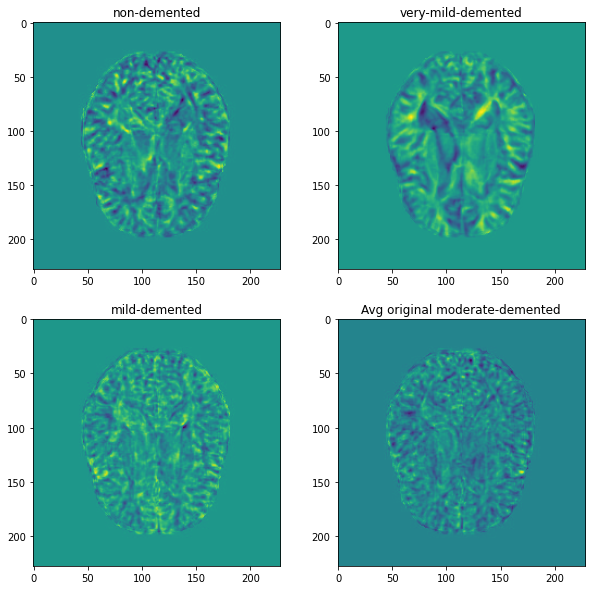

In [ ]:
fig = plt.figure(figsize = (10,10))
axs = fig.subplots(2,2)
axs[0][0].set_title('non-demented')
axs[0][1].set_title('very-mild-demented')
axs[1][0].set_title('mild-demented')
axs[1][1].set_title('moderate-demented')
axs[0][0].imshow(coefs[0])
axs[0][1].imshow(coefs[1])
axs[1][0].imshow(coefs[2])
axs[1][1].imshow(coefs[3])

We can see in these images, even though it is not quite immediately apparent, that the local variances in weights seem higher in the outer region, where the gray matter is located. In other words, the local complexity of the images is being kept with the weights. There is also a slight color difference between the middle and the outer parts, where on average the outer parts are just a bit brighter.

Our data is somewhat ordered: we have increasingly severe demetia classes. A misclassification between two near classes (e.g. Very-Mildly-demented classified as Non-Demented) isn't as wrong as a far misclassification.
For this reason, just measuring correct classifications doesn't fully represent how well the regressor performed.  
We use confusion matrices extensively in this project, to determine the types of errors we find in the models. Each cell (i, j) gives us how many data items of type i were classified as type j. For example, cell (0, 1) shows that 13 NonDemented images were wrongly classified as VeryMildDemented.

In [ ]:
test_predictions = logr.predict(ori_images)
pd.DataFrame(sklearn.metrics.confusion_matrix(ori_classes, test_predictions, labels=["NonDemented", "VeryMildDemented", "MildDemented","ModerateDemented"]))

0     1    2   3
0  3186    13    1   0
1    20  2216    4   0
2     4    14  878   0
3     0     0    1  63

Next we start with the augmented dataset. Here we have the same regressor as before, trained on much more data. The training was done before, and we just load the trained model here.

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(aug_images, aug_classes)

In [ ]:
# logr = LogisticRegression(max_iter=400,class_weight="balanced").fit(x_train, y_train)
# logr.score(x_test, y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.756120527306968

In [ ]:
# pickle.dump(logr, open('Logr_full_imgs.pickle', "wb"))

In [ ]:
logr = pickle.load(open('Logr_full_imgs.pickle', "rb"))

Again we want to see what exactly the model thinks is important (in the augmented data this time). We use the same technique as before - an image of the weights:

In [ ]:
coefs = logr.coef_
coefs = coefs.reshape((4,228,228))

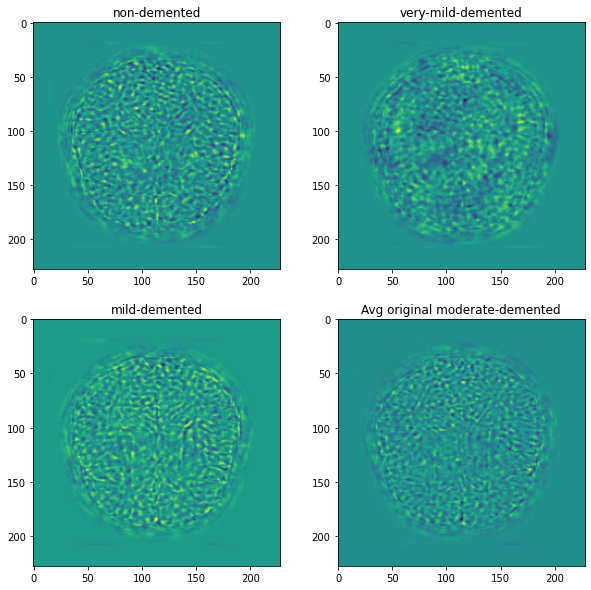

In [ ]:
fig = plt.figure(figsize = (10,10))
axs = fig.subplots(2,2)
axs[0][0].set_title('non-demented')
axs[0][1].set_title('very-mild-demented')
axs[1][0].set_title('mild-demented')
axs[1][1].set_title('moderate-demented')
axs[0][0].imshow(coefs[0])
axs[0][1].imshow(coefs[1])
axs[1][0].imshow(coefs[2])
axs[1][1].imshow(coefs[3])

Surprisingly, in the augmented data there does not seem to be any clear pattern. perhaps the size of the data did not allow the regressor to properly converge. Before we had images resembling a brain, but here we seem to just get noisy circles.  
  
Looking at the confusion matrix of the original data classified by the model trained on the augmented images:

In [ ]:
print(logr.score(ori_images, ori_classes))
test_predictions = logr.predict(ori_images)
pd.DataFrame(sklearn.metrics.confusion_matrix(ori_classes, test_predictions, labels=["NonDemented", "VeryMildDemented", "MildDemented","ModerateDemented"]))

0.315625


0     1    2    3
0  628  1822   85  665
1  267  1239  156  578
2  103   465   92  236
3    0     3    0   61

It is interesting to see that the model had a strong bias towards the second and fourth class. If we look at this image again:  
  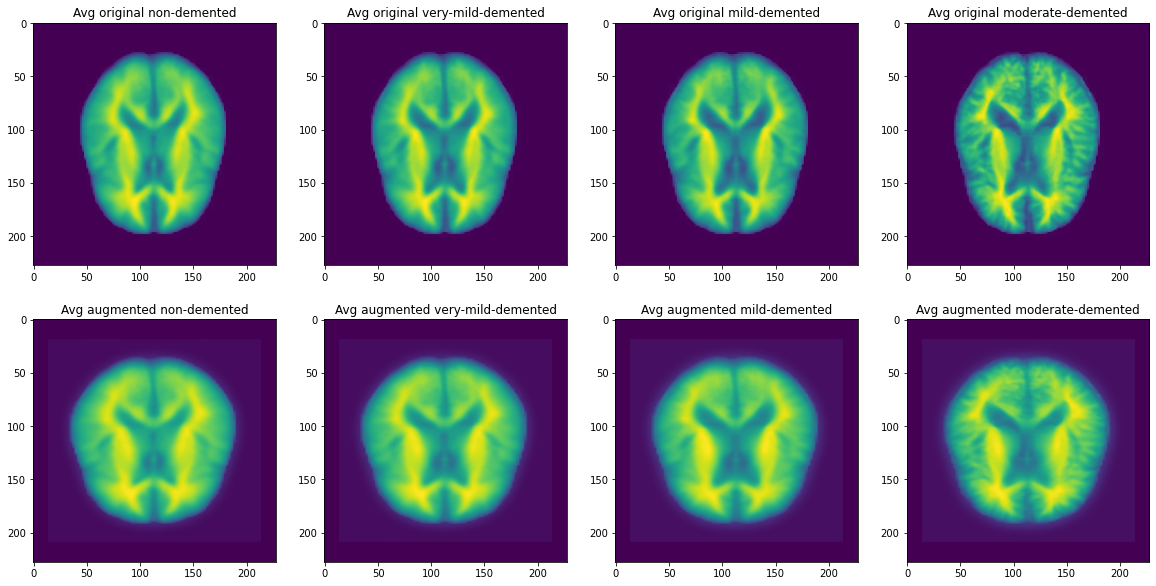

We could try and explain this bias towards the ModerateDemented class like this:  
The augmented data has rounder outlines, and therefore after the regressor applied weights to the pixels at the sides of brain image, the original data filled the outer outlines with zeros
where the augmented data had actual information about gray matter sparsity. This was interperted by the model as gray matter decay, and therefore we have a strong bias towards dementia.  
This explanation sounds nice, but it still doesn't explain the bias towards the VeryMildDemented class that we saw. In fact, such an effect would have probably caused a much stronger bias towards the most demented class than what we actually found.

## lowering resolution  
The next thing we want to try is to simply lower the resolution of our images significantly to (32x32) pixels. We hope this would help add more significance to decaying in whole regions of an MRI so that the model does not have to learn relantionships between pixels, but instead try to find information heavy sections in the MRI.

The next few cells turn the vectors we used for the logistic regressor back into images, and run them through the pixel_pooling_vectorize() function that calculates means of 32x32 buckets in the images and returns them as a vector (well, a matrix really... it's the same image with much lower resolution).

In [ ]:
ori_images = np.reshape(ori_images,(len(ori_images),IMG_NORMAL_SIZE,IMG_NORMAL_SIZE))

In [ ]:
aug_images = np.reshape(aug_images,(len(aug_images),IMG_NORMAL_SIZE,IMG_NORMAL_SIZE))

In [ ]:
INTERVAL = 32
def pixel_pooling_vectorize(img):
  num = int(IMG_NORMAL_SIZE // INTERVAL)
  vec = np.zeros((INTERVAL, INTERVAL))
  for i in range(INTERVAL):
    x = i * num
    for j in range(INTERVAL):
      y = j * num
      vec[i,j] = np.mean(img[x:x+num, y:y+num])
    
  return vec

def coll_vectorize_util(imgs):
  res = []
  for img in imgs:
    res.append(pixel_pooling_vectorize(img))
  
  return np.array(res)

In [ ]:
# ori_low_res = coll_vectorize_util(ori_images)
# np.save('original_data_low_res', ori_low_res)

In [ ]:
# aug_low_res = coll_vectorize_util(aug_images)
# np.save('augmented_data_low_res', aug_low_res)

In [ ]:
ori_low_res = np.load('original_data_low_res.npy')

In [ ]:
aug_low_res = np.load('augmented_data_low_res.npy')

And below we see examples of the results. The first row is two random original data samples, the lower row is from the augmented images.  
We can still see that the augmented data is differently shaped.

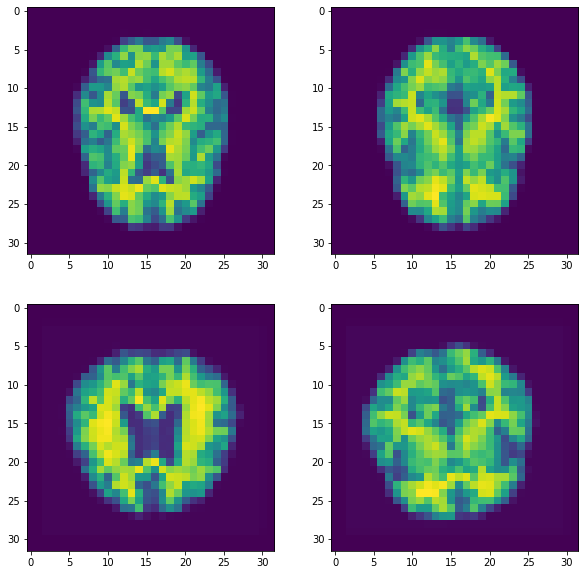

In [ ]:
fig = plt.figure(figsize = (10,10))
axs = fig.subplots(2,2)
axs[0][0].imshow(random.choice(ori_low_res))
axs[0][1].imshow(random.choice(ori_low_res))
axs[1][0].imshow(random.choice(aug_low_res))
axs[1][1].imshow(random.choice(aug_low_res))

We want to retry the regressor on the new images, with the same format - split the augmented data to a training and test set, then try the originals.

In [ ]:
ori_low_res = np.reshape(ori_low_res, (ori_low_res.shape[0],-1))

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(ori_low_res, ori_classes)

In [ ]:
logr_lowres = LogisticRegression(max_iter=10000,class_weight="balanced").fit(x_train, y_train)
logr_lowres.score(x_test, y_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.749375

The score is decent, but this is on the original data. Let's repeat the process from before, and try to locate the important regions in the image.

In [ ]:
coefs = logr_lowres.coef_
coefs = coefs.reshape((4,INTERVAL,INTERVAL))

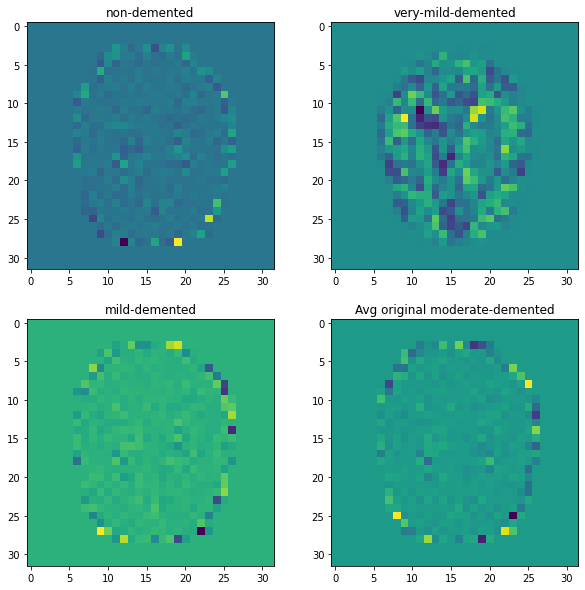

In [ ]:
fig = plt.figure(figsize = (10,10))
axs = fig.subplots(2,2)
axs[0][0].set_title('non-demented')
axs[0][1].set_title('very-mild-demented')
axs[1][0].set_title('mild-demented')
axs[1][1].set_title('Avg original moderate-demented')
axs[0][0].imshow(coefs[0])
axs[0][1].imshow(coefs[1])
axs[1][0].imshow(coefs[2])
axs[1][1].imshow(coefs[3])

It looks like the classifier is focusing on the gray matter region (it is easier to see in the very-mild-demented image, where the matplotlib normalization of the background is not so misleading).

The matrix also shows good results:

In [ ]:
test_predictions = logr_lowres.predict(ori_low_res)
pd.DataFrame(sklearn.metrics.confusion_matrix(ori_classes, test_predictions, labels=["NonDemented", "VeryMildDemented", "MildDemented","ModerateDemented"]))

0     1    2   3
0  2582   472  146   0
1   349  1790  101   0
2    28    31  837   0
3     0     0    0  64

Repeating the process for the augmented data:

In [ ]:
aug_low_res = np.reshape(aug_low_res, (len(aug_low_res), INTERVAL ** 2))

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(aug_low_res, aug_classes)

In [ ]:
# logr_lowres = LogisticRegression(max_iter=10000,class_weight="balanced").fit(x_train, y_train)
# logr_lowres.score(x_test, y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6423022598870056

We see that the regression performs worse. Possibly the amount of data means that intricacies are lost with lower resolution when the dataset is so large.

In [ ]:
# pickle.dump(logr_lowres, open('Logr_lowres.pickle', "wb"))

In [ ]:
logr_lowres = pickle.load(open('Logr_lowres.pickle', "rb"))

In [ ]:
coefs = logr_lowres.coef_
coefs = coefs.reshape((4,INTERVAL,INTERVAL))

Again we want to see what the regression learns, with the weight-image:

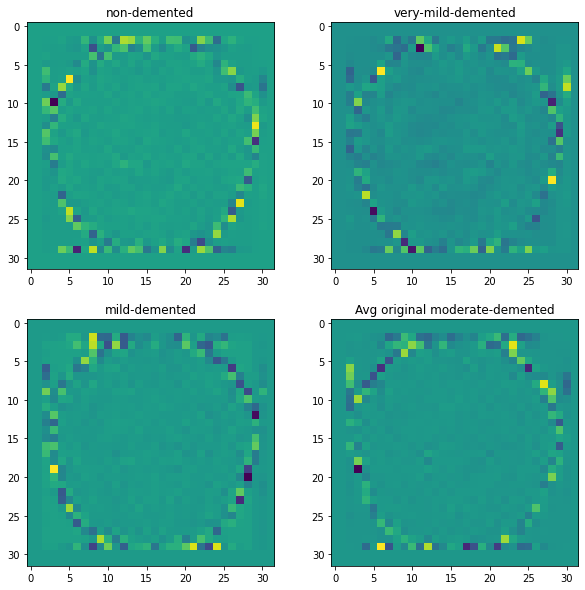

In [ ]:
fig = plt.figure(figsize = (10,10))
axs = fig.subplots(2,2)
axs[0][0].set_title('non-demented')
axs[0][1].set_title('very-mild-demented')
axs[1][0].set_title('mild-demented')
axs[1][1].set_title('Avg original moderate-demented')
axs[0][0].imshow(coefs[0])
axs[0][1].imshow(coefs[1])
axs[1][0].imshow(coefs[2])
axs[1][1].imshow(coefs[3])

We see that the structure is very much similar to what we saw with the original data, with an adaptation to the shape of the augmented images. This does not bode well for the generalization capabilities of this lowered resolution model in fact, looking at the results. we see a performance that is very slightly worse than completely random classification...

In [ ]:
print(logr_lowres.score(ori_low_res, ori_classes))
test_predictions = logr_lowres.predict(ori_low_res)
pd.DataFrame(sklearn.metrics.confusion_matrix(ori_classes, test_predictions, labels=["NonDemented", "VeryMildDemented", "MildDemented","ModerateDemented"]))

0.23


0     1   2     3
0  108  1784  62  1246
1   13  1242  77   908
2    3   484  59   350
3    0     1   0    63

It's time to try somthing new, and that is decision trees. Hopefully the trees can find dependent patterns that the logistic regressors couldn't, and give better results.  
We're using the low resolution images for a better comparison with the regression model, that performed so poorly with them.

In [ ]:
dctr = DecisionTreeClassifier().fit(x_train, y_train)
dctr.score(x_test, y_test)

0.5982815442561206

In [ ]:
dctr.score(np.reshape(ori_low_res, ((len(ori_low_res), INTERVAL ** 2))), ori_classes)

0.3884375

We got worse results on the augmented data, but is seems that this model carried over better to the original images. Still didn't do great, but better than both the regressions we have. The confusion matrix below suggests that this is because the tree learned much less than the regressors, and by that we mean it did not learn the incredible bias that the regressors had.

In [ ]:
test_predictions = dctr.predict(np.reshape(ori_low_res, ((len(ori_low_res), INTERVAL ** 2))))
pd.DataFrame(sklearn.metrics.confusion_matrix(ori_classes, test_predictions,labels=["NonDemented", "VeryMildDemented", "MildDemented","ModerateDemented"]))

0    1    2    3
0  1506  833  519  342
1   897  678  462  203
2   285  233  280   98
3    12   11   19   22

## HOG - Histogram of Oriented Gradients  
continuing our exploration for patterns rising from the gray matter area of the MRI, we want to represent the images in gradient form in an attempt to focus on the rapid intensity changes in the gray matter area of the images.  
We will try the logistic regressor and the tree again, this time on the HOG feature decriptor vectors of the datasets.

The function below takes a collection of images and returns the HOG feature description arrays of those images.

In [ ]:
def coll_hog_util(imgs):
  hogs = []
  for img in imgs:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)
    hogs.append(fd)
  
  return np.array(hogs)

Now we use the above function to create two new data collections.

In [ ]:
aug_images = np.reshape(aug_images,(-1,228,228))

In [ ]:
ori_images = np.reshape(ori_images,(-1,228,228))

In [ ]:
# ori_hogs = coll_hog_util(ori_images)
# np.save('original_data_hogs', ori_hogs)

In [ ]:
# aug_hogs = coll_hog_util(aug_images)
# np.save('augmented_data_hogs', aug_hogs)

In [ ]:
ori_hogs = np.load('original_data_hogs.npy')

In [ ]:
aug_hogs = np.load('augmented_data_hogs.npy')

First we run another logistic regressor - which on the augmented set performed worse than the full image regressor and better than the low resolution one, which seems reasonable as the hog vectors could be interperted as a sort of in between reolution.


In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(ori_hogs, ori_classes)

In [ ]:
logr_hog = LogisticRegression(max_iter=10000,class_weight="balanced").fit(x_train, y_train)
logr_hog.score(x_test, y_test)

0.640625

There doesnt seem to be any significant change, the model performs about as well as the low resolution one.  
We repeat the steps above for the new regressor - looking at the weights, training on the original data then checking the generalization, but we don't expect anything interesting to change.  

Now training on the HOG augmented data.

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(aug_hogs, aug_classes)

In [ ]:
logr_hog = LogisticRegression(max_iter=10000,class_weight="balanced").fit(x_train, y_train)
logr_hog.score(x_test, y_test)

0.6806732580037664

After all this, it seems that the hog really did act as some intermidiate resolution: it performs somewhere between the regressor on the full images and the regressor on the low resolution images.

The score:

In [ ]:
logr_hog.score(ori_hogs, ori_classes)

0.28046875

And the confusion matrix, with the same bias that we recognize from the previous regressors, this time without the bias towards VeryMildDemented class, only a bias towards ModerateDemented.

In [ ]:
test_predictions = logr_hog.predict(ori_hogs)
pd.DataFrame(sklearn.metrics.confusion_matrix(ori_classes, test_predictions,labels=["NonDemented", "VeryMildDemented", "MildDemented","ModerateDemented"]))

0    1   2     3
0  1320  633  27  1220
1   475  701  32  1032
2   150  182  49   515
3     0    0   0    64

Next we try the decision tree again - with the HOGs. The augnented tests show a worse performance.

In [ ]:
# dctr_hog = DecisionTreeClassifier().fit(x_train, y_train)
# dctr_hog.score(x_test, y_test)

0.53825329566855

In [ ]:
# pickle.dump(dctr_hog, open('dctr_hog.pickle', "wb"))

In [ ]:
dctr_hog = pickle.load(open('dctr_hog.pickle', "rb"))

The performance on the original data worsened by a rather large factor, from 38% to 31%. The tree doesn't seem to like the hog representation, and has a harder time finding specific gradients that are more meaningful than others, rather than choosing image locations. 

In [ ]:
dctr_hog.score(ori_hogs, ori_classes)

0.3165625

In [ ]:
test_predictions = dctr_hog.predict(ori_hogs)
pd.DataFrame(sklearn.metrics.confusion_matrix(ori_classes, test_predictions,labels=["NonDemented", "VeryMildDemented", "MildDemented","ModerateDemented"]))

0    1    2    3
0  1027  835  961  377
1   660  625  656  299
2   229  206  351  110
3    18    9   14   23

#The deep section: using deep learning strategies

##Prepering Data for classifiers

The cells below reload the data from memory. We've seen these steps before, but we repeat them here to prevent any precomputations from previous sections meddling with our data.

In [ ]:
dementia_types = ['NonDemented','VeryMildDemented', 'MildDemented', 'ModerateDemented']
images = []
for name in dementia_types:
  images.append(np.load(name+'_augmented_normalized.npy'))


In [ ]:
stacked = np.vstack(images)

In [ ]:
map = {'NonDemented': np.array([1,0,0,0]),'VeryMildDemented': np.array([0,1,0,0]), 'MildDemented': np.array([0,0,1,0]), 'ModerateDemented': np.array([0,0,0,1])}
classes = []
for i, name in enumerate(dementia_types):
  for _ in range(images[i].shape[0]):
    classes.append(map[name])

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(stacked, classes)


In [ ]:
x_train.shape

(25488, 228, 228)

We use the Dataset utility from tensor in the training neural networks, because of the high ram usage these training procedures take. The batching should help prevent crashes from RAM depletions (we experienced some of these in previous training attempts).

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [ ]:
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

#CNN classifier

We build a classic CNN, with a few convolution layers followed by a few dence layers.
The CNN inputs an image and the final layer is made out of 4 cells that give the probability destribution over the classes of dementia.  
CNN is what we consider the 'standard' type of classification. We know they work, we know they're powerful, and we know they work well with image data. The section below is simply us building a network, training it and testing it's generalization capabilities from the augmented data to the originals.

In [ ]:
cnn = keras.Sequential()
cnn.add(keras.Input(shape = (228,228,1)))
cnn.add(layers.Conv2D(32, 3, activation="relu"))
cnn.add(layers.Conv2D(32, 3, activation="relu"))
cnn.add(layers.MaxPooling2D(3))
cnn.add(layers.Conv2D(32, 3, activation="relu"))

cnn.add(layers.GlobalMaxPooling2D())

cnn.add(layers.Flatten())
cnn.add(layers.Dense(32))
cnn.add(layers.Dense(32))
cnn.add(layers.Dense(32))
cnn.add(layers.Dense(4, activation = 'softmax'))

cnn.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 226, 226, 32)      320       
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 global_max_pooling2d_4 (Glo  (None, 32)               0         
 balMaxPooling2D)                                                
                                                                 
 flatten_4 (Flatten)         (None, 32)               

Like most classification networks, we use crossentropy as a loss function.

In [ ]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

In [ ]:
history = cnn.fit(train_dataset, epochs=20,
                 batch_size=20,
                 shuffle=True,
                  validation_data = test_dataset
)

In [ ]:
#cnn.save_weights('cnn_weights.tf')

In [ ]:
cnn.load_weights('cnn_weights.tf')

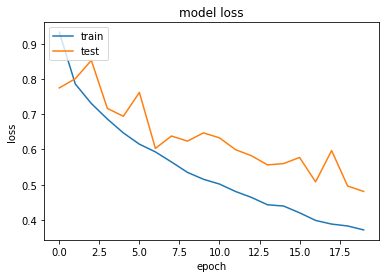

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

There seems to be slight overfitting near the end of the training, but not a lot. Overall, we see a steady learning rate for most of the training.

Now we test the results: first on the augmented data:

In [ ]:
preds = cnn.predict(x_test)

In [ ]:
x_res = []
y_res = []
for i in range(preds.shape[0]):
  maxx = 0
  maxy=0
  for j in range(4):
    if preds[i,j] > preds[i,maxx]:
      maxx=j
    if y_test[i][j] > y_test[i][maxy]:
      maxy=j
  x_res.append(maxx)
  y_res.append(maxy)


In [ ]:
score = sum([x==y for x,y in zip(x_res,y_res)])

In [ ]:
score/=len(x_res)

The percentage of the augmented test data the CNN got correct:



In [ ]:
score

0.807791902071563

And the confusion matrix:

In [ ]:
pd.DataFrame(sklearn.metrics.confusion_matrix(y_res, x_res))

0     1     2     3
0  1789   487   139     7
1   404  1595   238     6
2    76   230  1906     6
3     0    11    29  1573

We can see that even when the CNN makes a mistake it more often the not, to a neighboring class.

Now for the real test, the results on the original data. We repeat the dataloading steps in the next 5 cells, then predict with the CNN.

In [ ]:
dementia_types = ['NonDemented','VeryMildDemented', 'MildDemented', 'ModerateDemented']
images = []
for name in dementia_types:
  images.append(np.load('../NormedOriginalDataByTypes/' + name + '.npy'))


In [ ]:
stacked = np.vstack(images)

In [ ]:
map = {'NonDemented': np.array([1,0,0,0]),'VeryMildDemented': np.array([0,1,0,0]), 'MildDemented': np.array([0,0,1,0]), 'ModerateDemented': np.array([0,0,0,1])}
classes = []
for i, name in enumerate(dementia_types):
  for _ in range(images[i].shape[0]):
    classes.append(map[name])

In [ ]:
org_dataset = tf.data.Dataset.from_tensor_slices((stacked,classes))

In [ ]:
org_dataset = org_dataset.batch(BATCH_SIZE)

In [ ]:
preds = cnn.predict(stacked)



200/200 [==============================] - 1s 3ms/step


In [ ]:
x_res = []
y_res = []
for i in range(preds.shape[0]):
  maxx = 0
  maxy=0
  for j in range(4):
    if preds[i,j] > preds[i,maxx]:
      maxx=j
    if classes[i][j] > classes[i][maxy]:
      maxy=j
  x_res.append(maxx)
  y_res.append(maxy)


In [ ]:
score = sum([x==y for x,y in zip(x_res,y_res)])

In [ ]:
score/=len(x_res)

The score:

In [ ]:
score

0.64421875

And the confusion matrix.

In [ ]:
pd.DataFrame(sklearn.metrics.confusion_matrix(y_res, x_res))

0     1    2   3
0  2628   479   93   0
1   987  1133  119   1
2   280   283  333   0
3    27     0    8  29

We get a 64% accuracy, our best result yet by a large margin. The deep model outperformed the classical ones, by about a factor of 2. That's not very surprising, as neural networks are known to be great generalizors. However, We see here something interesting: the model confuses moderate dementia (the worst type we have in the data) with no dementia. In the EDA section we saw that the overall brightness of the moderate-demented class was higher than it should have been, according to the trend we saw in the other classes. This might be some sort of corrolatory result.

#First Autoencoder
Our first attempt at compressing the data stored in the images. The encoder network reduces the dimensionality of each image to 16 values, then the decoder tries to reassemble the original image from that vector. They are trained together as the autoencoder, and the result should be an encoder with high compression abilities.

In [ ]:
encoder_input = keras.Input(shape = (228,228,1))
x = layers.Conv2D(32, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)


decoder_input = encoder_output

x = layers.Dense(16)(decoder_input)
x = layers.Dense(16)(x)
x = layers.Dense(16)(x)
x = layers.Dense(16)(x)

x = layers.Reshape((4, 4, 1))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D((8,8))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

encoder.summary()
autoencoder.summary()
decoder.summary()

We added a graph to show exactly how the network is built. We gradually reduce the dimesionality to 16, then raise it back to our image size.

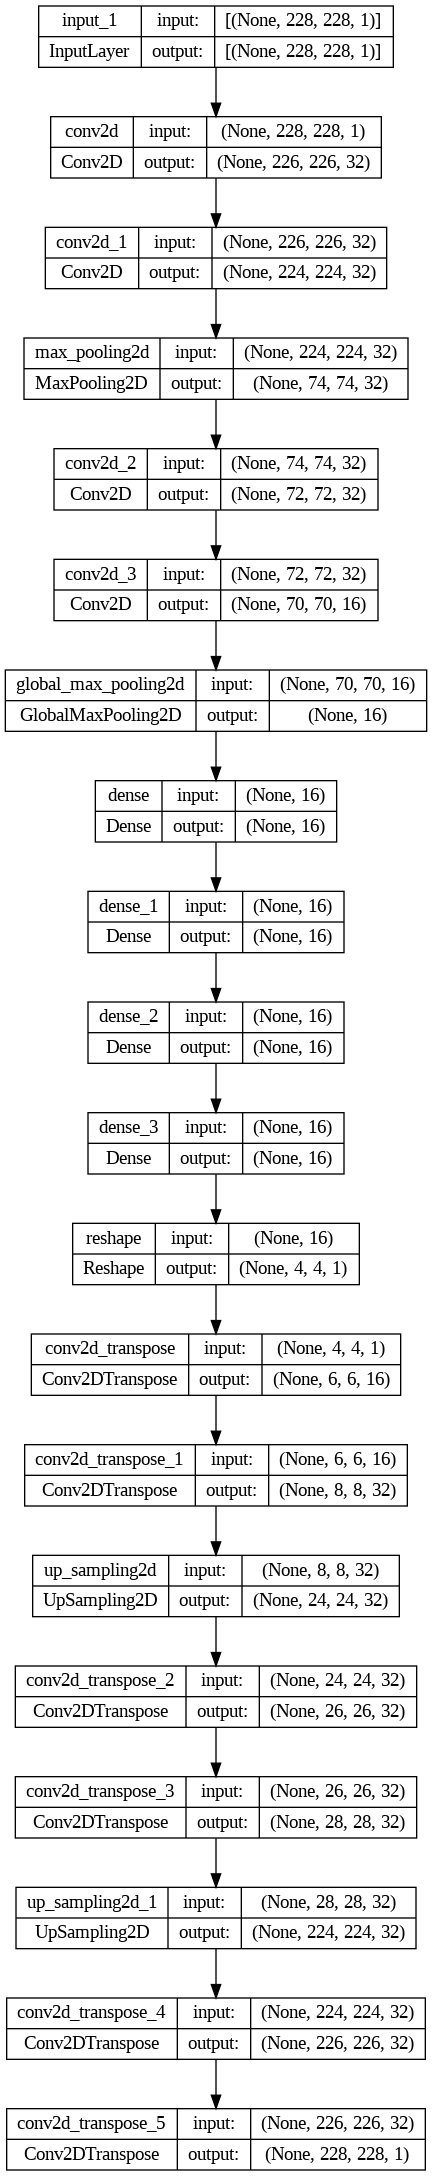

In [ ]:
keras.utils.plot_model(autoencoder,  show_shapes=True)


In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

###Prepare data
Here we load the data for training from the array file and the corresponding classes CSV. 

In [ ]:
pd.pivot_table(classes, values = 'Unnamed: 0', columns = '0', aggfunc = 'count')

0           MildDemented  ModerateDemented  NonDemented  VeryMildDemented
Unnamed: 0          8960              6464         9600              8960

In [ ]:
autoencoder.load_weights('autoencoder_w_final.tf')

In [ ]:
dementia_types = ['NonDemented','VeryMildDemented', 'MildDemented', 'ModerateDemented']
images = []
for name in dementia_types:
  images.append(np.load(name+'_augmented_normalized.npy'))


In [ ]:
stacked = np.vstack(images)

Due to the loss function we need to first normilize the data:

In [ ]:
stacked = stacked.astype('float32')/255

In [ ]:
stacked = np.reshape(stacked, (-1,228,228,1))

In [ ]:
map = {'NonDemented': np.array([1,0,0,0]),'VeryMildDemented': np.array([0,1,0,0]), 'MildDemented': np.array([0,0,1,0]), 'ModerateDemented': np.array([0,0,0,1])}
classes = []
for i, name in enumerate(dementia_types):
  for _ in range(images[i].shape[0]):
    classes.append(map[name])

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(stacked, classes)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,x_test))

In [ ]:
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
# data_part = 10 #out of 10
history = autoencoder.fit((train_dataset),
                epochs=5,
                validation_data = (test_dataset)
                )

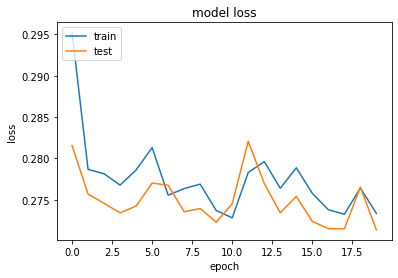

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#autoencoder.save_weights('autoencoder_w_final.tf')

##Let's take a look at the results:

In [ ]:
image = stacked[500]

In [ ]:
norm_image = image.astype('float16')/255.0

The original image before passing through the autoencoder:

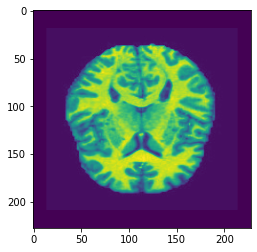

In [ ]:
plt.imshow(np.reshape(image,(228,228)))

Now the result of encoding and decoding the image

In [ ]:
result = np.reshape(autoencoder(np.reshape(image, (1,228,228,1))),(228,228))

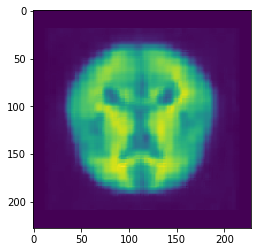

In [ ]:
plt.imshow(result.astype('float32'))

Obviously, we can't expect a perfect reassembly of the original image after reducing it to 16 values, but the result is looking quite good for such a violent compression. The general structure of the original MRI is quite present.  
Let's see if the encoder is good enough for a logistic regressor to use encoded representations for classifying dementia.

##Encoding the original data
in this step we load the data from the original dataset and encode it with the encoder part of the autoencoder, giving us the a new features dataset in compressed form. Like in the steps above, some of the source code is commented. We saved the encoded features in a new array file and we use that directly.

In [ ]:
dementia_types = ['NonDemented','VeryMildDemented', 'MildDemented', 'ModerateDemented']
images = []
for name in dementia_types:
  images.append(np.load('../NormedOriginalDataByTypes/' + name + '.npy'))


In [ ]:
stacked = np.vstack(images)

In [ ]:
map = {'NonDemented': np.array([1,0,0,0]),'VeryMildDemented': np.array([0,1,0,0]), 'MildDemented': np.array([0,0,1,0]), 'ModerateDemented': np.array([0,0,0,1])}
classes = []
for i, name in enumerate(dementia_types):
  for _ in range(images[i].shape[0]):
    classes.append(name)

In [ ]:
org_dataset = tf.data.Dataset.from_tensor_slices((stacked,stacked))

In [ ]:
org_dataset = org_dataset.batch(BATCH_SIZE)

In [ ]:
features = encoder.predict(org_dataset)

320/320 [==============================] - 4s 12ms/step


In [ ]:
features.shape

(6400, 16)

In [ ]:
features = pd.DataFrame(features, columns = [str(i) for i in range(16)])

In [ ]:
features.describe()

0            1            2            3            4  \
count  6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean     84.229179    12.216742     7.982255   548.976807   306.769440   
std      22.601477     6.066188     4.471429    43.108055    41.109997   
min      20.340424     0.507883     0.048205   289.338501   143.767670   
25%      67.403463     7.842623     4.902562   534.346130   277.693535   
50%      84.965988    11.392230     7.600527   557.503693   305.222198   
75%     100.251900    15.454668    10.674679   576.783249   336.925201   
max     158.367630    47.224026    31.838919   628.323608   414.747406   

                 5            6            7            8            9  \
count  6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean    192.940994     0.199413     4.423259   491.568176     3.323905   
std      51.668358     0.518505     5.646244    66.308685     4.145409   
min      74.169380     0.000000     0.000000   245.072540     0.000000   
25%     150.582561     0.000000     0.211755   444.467209     0.344863   
50%     192.413887     0.000000     1.956617   488.471558     1.244467   
75%     233.933990     0.124998     7.158900   547.619598     5.292245   
max     315.112335     9.795175    40.604290   642.811218    30.766981   

                10           11           12           13           14  \
count  6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean    248.821732    27.529539   209.513123   682.616333     1.510493   
std      33.896847    16.582579    47.440304    77.544823     0.980995   
min     130.872818     0.562321    76.289307   353.300385     0.404199   
25%     226.739933    13.974785   173.318382   628.223038     0.879286   
50%     247.641190    25.276170   208.420387   680.059265     1.186396   
75%     270.464645    39.942456   244.492977   742.973221     1.774563   
max     375.440002    98.458687   358.759277   873.711670    10.575569   

                15  
count  6400.000000  
mean     49.788525  
std      15.945752  
min      16.571804  
25%      37.896911  
50%      48.133097  
75%      59.304765  
max     121.451538

##Sanity test - decode mean features
We run the means of the features through the decoder to make sure that the result makes sense, and resembles a brain. We say 'means' and speak quite literally in the numeric fashion - run the means from the dataframe above through the decoder. Assuming the means are the decoded values of an average brain, the decoder should output something that looks like an average brain (after it's been compressed to 16 dimensions).  
Important reminder: The means are of the encodings of the original dataset, and the autoencoder wasn't trained on any of these samples.

In [ ]:
mean_test = features.mean()

In [ ]:
mean_test_res = decoder(np.reshape(mean_test.values,(1,16)))

And an 'average' decompressed MRI scan looks like...

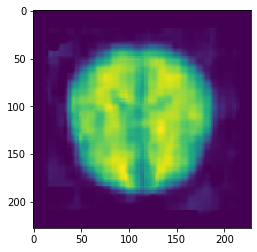

In [ ]:
plt.imshow(np.reshape(mean_test_res, (228,228)))

We found this result very impressive.  
Almost all of the major brain components are present.  
Let's check if a logistic regressor would think the same.

#Logistic Regression

Some utilities for stitching together the encodings file and the classes file

In [ ]:
classes= pd.DataFrame(classes, columns=['classes'])

In [ ]:
map = {'NonDemented': 1,'VeryMildDemented': 2, 'MildDemented': 3, 'ModerateDemented': 4}
reverse_map = {1: 'NonDemented',2: 'VeryMildDemented',3: 'MildDemented',4: 'ModerateDemented'}

In [ ]:
def encode(dat):
  return map[dat]

classes['encoded'] = classes['classes'].apply(encode)

And now, we can regress!

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(features, classes['encoded'])

In [ ]:
model = LogisticRegression(random_state=0,max_iter=100000,class_weight="balanced")
clf = model.fit(x_train, y_train)
clf.score(x_test, y_test)

0.39875

The score seems better than random results, but it's not fantastic.

##Analyzing the results

In [ ]:
predictions = clf.predict(features.values)
pred = pd.DataFrame(predictions)

def decode(dat):
  return reverse_map[dat]

classes['predicted'] = pred[0].apply(decode)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
classes['pred_encoded'] = classes['predicted'].apply(encode)

Here we show a confusion matrix for results:  
Each row gives us the distribution over the predicted class values.
So for example on row 2 column 1 we get the precentage of cases that are actually class 2 but where predicted to be in class 1.
the classes are ordered acording to dmentia severity.


In [ ]:
pd.DataFrame(sklearn.metrics.confusion_matrix(classes['encoded'], classes['pred_encoded'],normalize = 'true'))

0         1         2         3
0  0.517813  0.118125  0.186562  0.177500
1  0.293304  0.180357  0.300000  0.226339
2  0.127232  0.129464  0.513393  0.229911
3  0.156250  0.125000  0.093750  0.625000

Looking at the results we can see that it preformes better in the more extream cases, i.e. not demented and noderate demented. for the Very mild demented the performance in exceptionally bad.

#what do the features mean?
An interesting question we'd like to try and answer is 'what do the diffrent features created by the ecoder actully represent?'  
While we can't give an exact answer, some insight might be gained by looking at pictures created by the decoder when changing a single feature and keeping the rest constant.  
We do the following:  
Take the average values of all the encoder results, creating an 'average brain encoding' - a 16 feature vector.
we use Shaply values to foucus on the more important features.
For each of these features, we show the results of decoding the average brain, on the left - with its min value, in the middle with the median value and on the right with it's maxed out value (min, median and max with relation to the dataframe).

Permutation explainer: 1601it [00:52, 25.85it/s]


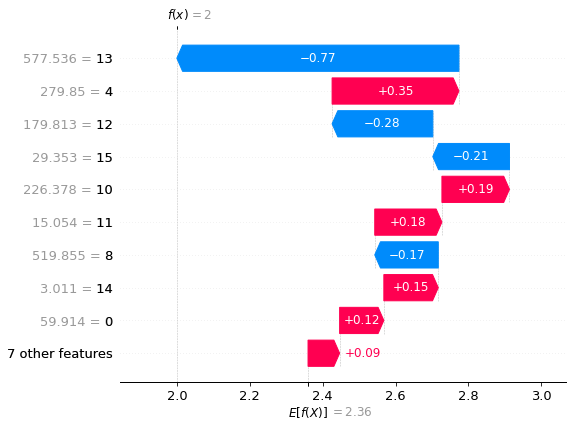

In [ ]:
expliner = shap.Explainer(clf.predict, x_test)
shap_v = expliner(x_test)
shap.plots.waterfall(shap_v[0])

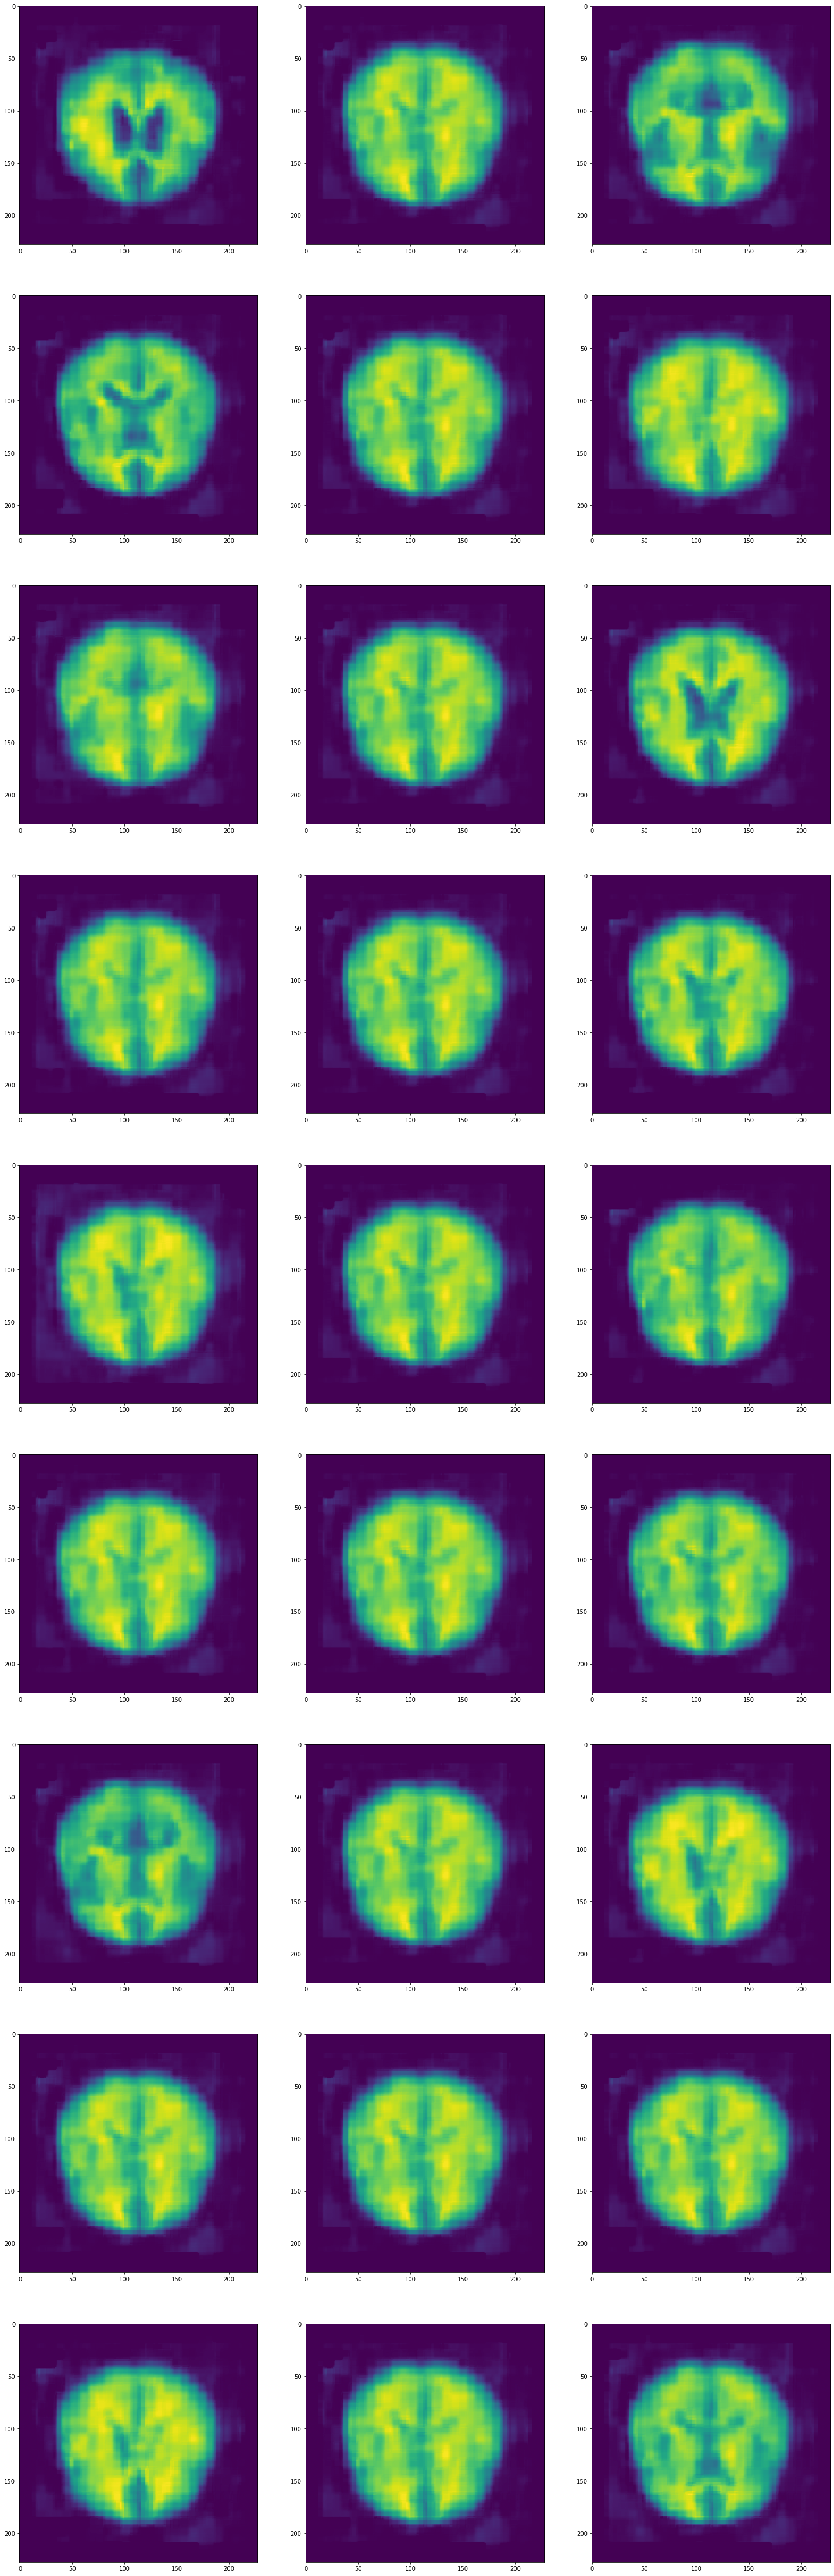

In [ ]:
mean_test = features.mean()

mean_test_res = decoder(np.reshape(mean_test.values,(1,16)))

features_to_print = ['13','4','12','15','10','11','8','14','0']

fig = plt.figure(figsize = (25,9*len(features_to_print)))
axs = fig.subplots(9,3)

ax = 0
for i in features_to_print:
  mean_test[i] = features[i].min()
  mean_test_res = decoder(np.reshape(mean_test.values,(1,16)))
  axs[ax][0].imshow(np.reshape(mean_test_res, (228,228)))
  
  mean_test[i] = features[i].median()
  mean_test_res = decoder(np.reshape(mean_test.values,(1,16)))
  axs[ax][1].imshow(np.reshape(mean_test_res, (228,228)))

  mean_test[i] = features[i].max()
  mean_test_res = decoder(np.reshape(mean_test.values,(1,16)))
  axs[ax][2].imshow(np.reshape(mean_test_res, (228,228)))

  mean_test[i] = features[i].mean()

  ax+=1
fig.show()

the first feature:

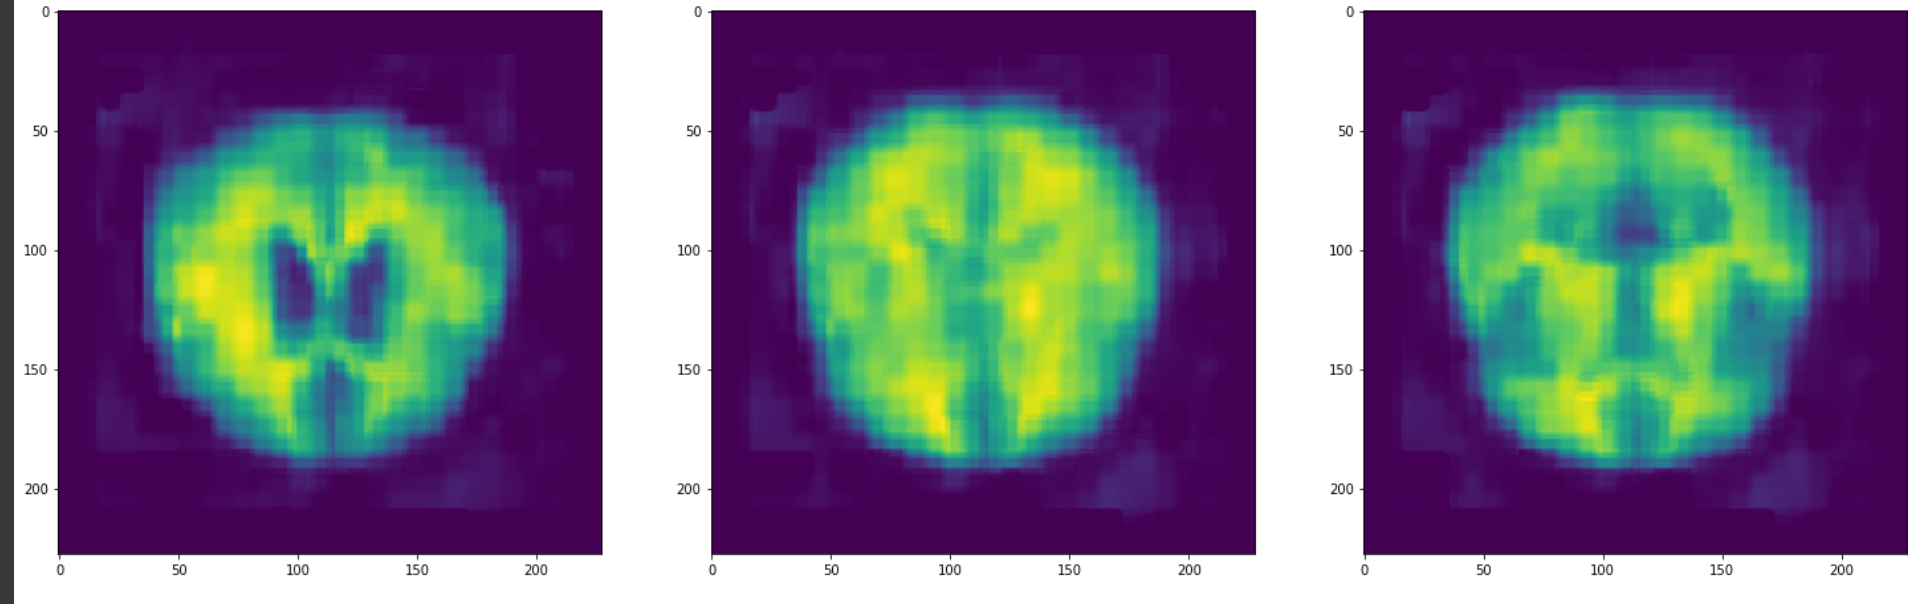

Seems to be a combination of how deep we are in the brain and the amount of grey matter.

#Second Autoencoder
In order to advance the performance of the linear regression on the decoded results, we decided to try a new encoder, with 2 major changes.  
1. The dimension reduction is much less violent - 64 features instead of 16.  
2. In the training process, the autoencoder gets losses from a second output, where the target is a correct classification of the demetia level. This is meant to push the encoder to encode those features which have the most meaning in dementia evaluation.


In [ ]:
dementia_types = ['NonDemented','VeryMildDemented', 'MildDemented', 'ModerateDemented']
images = []
for name in dementia_types:
  images.append(np.load(name+'_augmented_normalized.npy'))


In [ ]:
stacked = np.vstack(images)

In [ ]:
stacked = stacked.astype('float16')/255

In [ ]:
stacked = np.reshape(stacked, (-1,228,228,1))

In [ ]:
map = {'NonDemented': np.array([1,0,0,0]),'VeryMildDemented': np.array([0,1,0,0]), 'MildDemented': np.array([0,0,1,0]), 'ModerateDemented': np.array([0,0,0,1])}
classes = []
for i, name in enumerate(dementia_types):
  for _ in range(images[i].shape[0]):
    classes.append(map[name])

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(stacked, classes)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,(y_train,x_train)))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,(y_test,x_test)))

In [ ]:
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

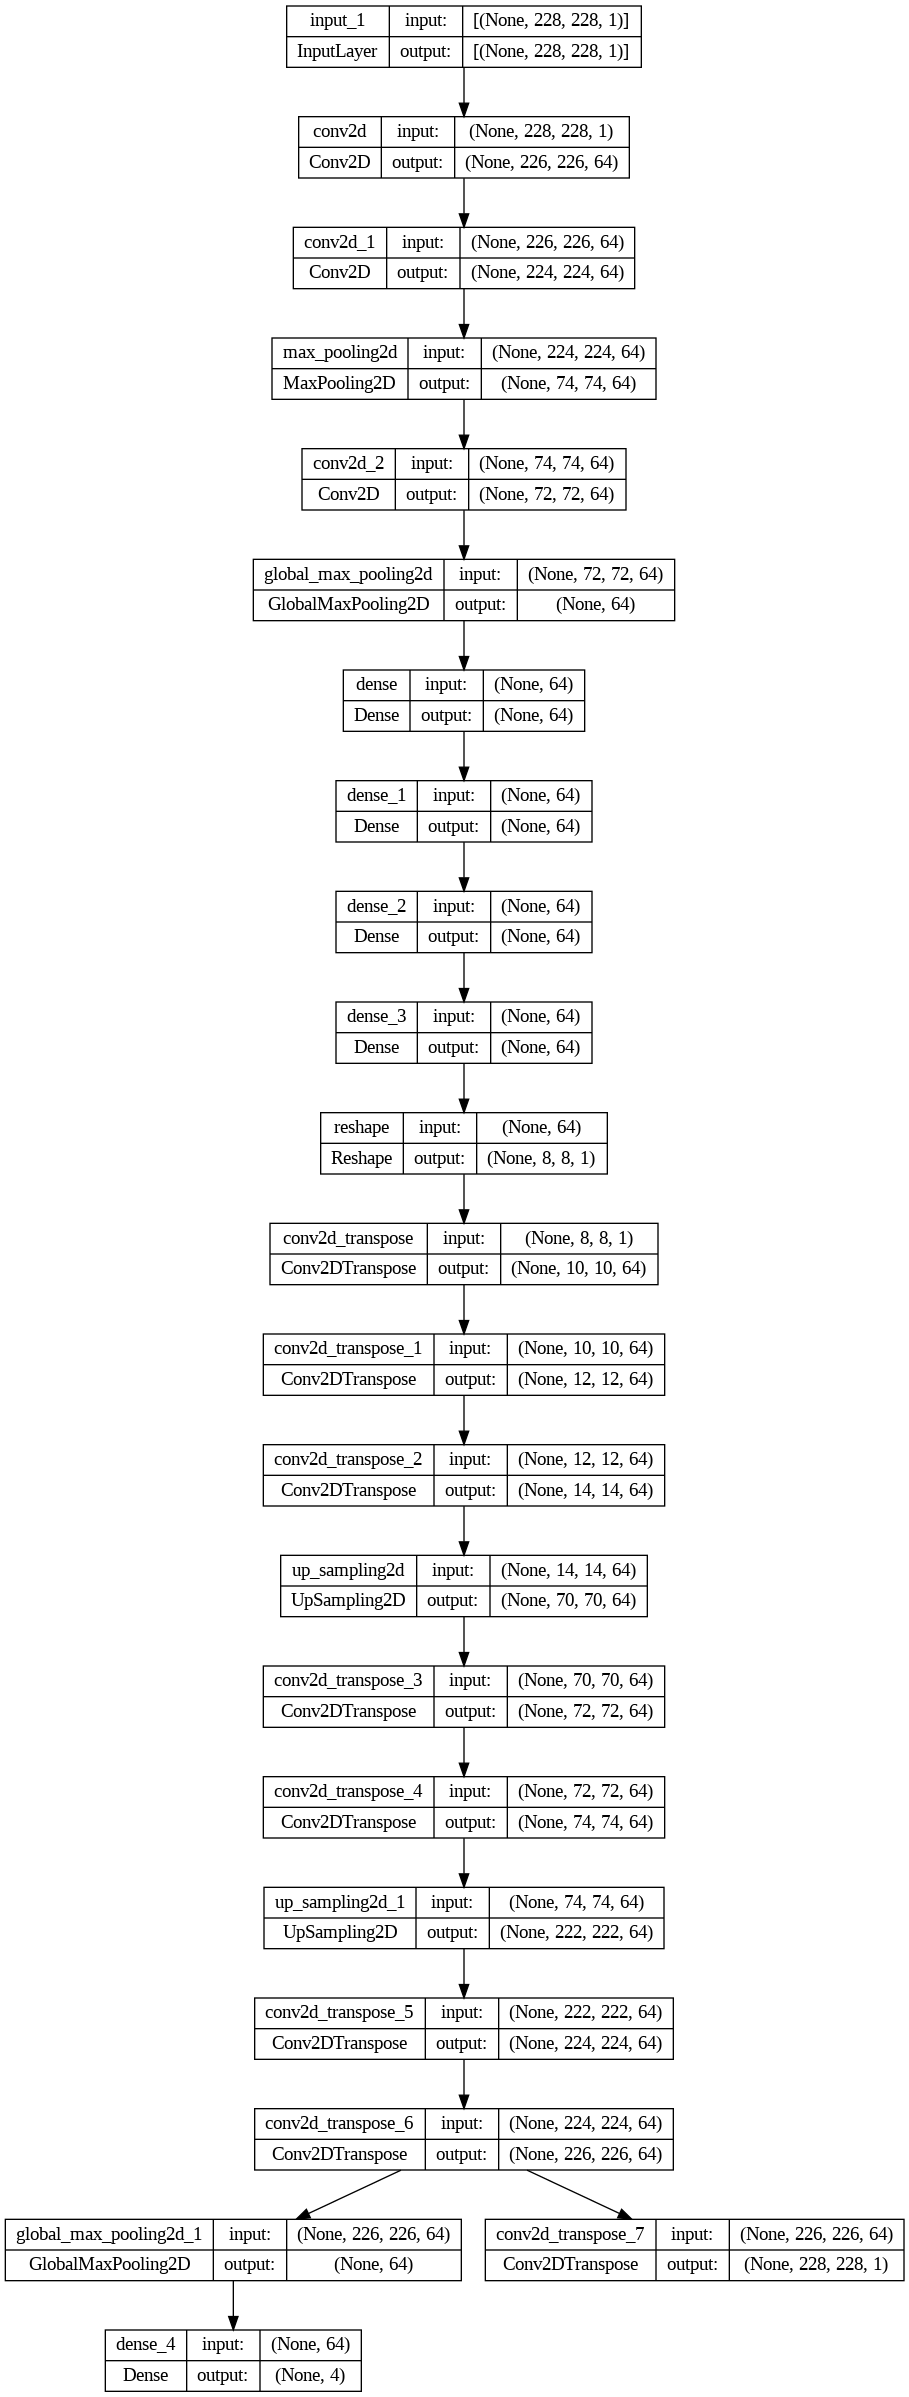

In [ ]:
encoder_input = keras.Input(shape = (228,228,1))
x = layers.Conv2D(64, 3, activation="relu")(encoder_input)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
decoder_input = encoder_output

x = layers.Dense(64)(decoder_input)
x = layers.Dense(64)(x)
x = layers.Dense(64)(x)
x = layers.Dense(64)(x)
# (for classic CNN) x = layers.Dense(4, activation = 'softmax')(x)  [1,0,0,0]

x = layers.Reshape((8, 8, 1))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu")(x)
x = layers.UpSampling2D(5)(x)
x = layers.Conv2DTranspose(64, 3, activation="relu")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu")(x)
x = layers.UpSampling2D((3,3))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

pool_before_bias = layers.GlobalMaxPooling2D()(x)
dementia_bias_output = layers.Dense(4,activation=keras.activations.softmax)(pool_before_bias)

bias_model = keras.Model(encoder_input, dementia_bias_output, name="encoder")
encoder = keras.Model(encoder_input, encoder_output, name="encoder")
autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
biased_autoencoder = keras.Model(
    inputs=[encoder_input],
    outputs=[dementia_bias_output,decoder_output]
)
keras.utils.plot_model(biased_autoencoder, show_shapes=True)

With this model, we also used keras callbacks to try and prevent some of the problems we've had in prototype networks which suffered heavily from overfitting.

In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

Compiling the biased autoencoder, with the losses and loss weights. Fitting the appropriate losses is not trivial, and we might decide to try and write a custom one. Our main fear is that the network will 'split', with one part trying to minimize one loss and another the second loss, without intercommunication.

In [ ]:
biased_autoencoder.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.CategoricalCrossentropy(),
        keras.losses.BinaryCrossentropy(),
    ],
    loss_weights=[0.1, 1]
)

In [ ]:
history = biased_autoencoder.fit(
    train_dataset,
    epochs=5,
    validation_data = test_dataset,
    callbacks=[callback]
  )

In [ ]:
#biased_autoencoder.save_weights('biased_autoencoder_final.tf')

In [ ]:
biased_autoencoder.load_weights('biased_autoencoder_final.tf')

We can see that the early stopper was in fact activated, and plotting the loss history shows that we were beginning to overfit.

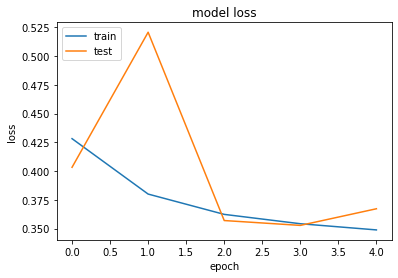

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Logistic Regression

open grey scaled images 

In [ ]:
mild = np.load('../NormedOriginalDataByTypes/MildDemented.npy')
moderate = np.load('../NormedOriginalDataByTypes/ModerateDemented.npy')
non = np.load('../NormedOriginalDataByTypes/NonDemented.npy')
veryMild = np.load('../NormedOriginalDataByTypes/VeryMildDemented.npy')

In [ ]:
imgs = np.vstack([non,veryMild,mild,moderate])

In [ ]:
imgs.shape

(6400, 228, 228)

normilize results

In [ ]:
imgs = imgs.astype(np.float16) / 255

In [ ]:
mild_c = ['MildDemented' for i in range(mild.shape[0])]
moderate_c = ['ModerateDemented' for i in range(moderate.shape[0])]
non_c = ['NonDemented' for i in range(non.shape[0])]
veryMild_c = ['VeryMildDemented' for i in range(veryMild.shape[0])]
classes = pd.DataFrame(non_c+veryMild_c+mild_c+moderate_c)

##running encoder on images
Due to size of the data we had to run it in batches to avoid GPU running out of RAM.

In [ ]:
%cd ../NormedOriginalDataByTypes

/content/drive/MyDrive/GitHub/data_science_project/NormedOriginalDataByTypes


In [ ]:
dementia_types = ['NonDemented','VeryMildDemented', 'MildDemented', 'ModerateDemented']
images = []
for name in dementia_types:
  images.append(np.load(name + '.npy'))


In [ ]:
stacked = np.vstack(images)

In [ ]:
stacked = stacked.astype('float32')/255.0

In [ ]:
map = {'NonDemented': np.array([1,0,0,0]),'VeryMildDemented': np.array([0,1,0,0]), 'MildDemented': np.array([0,0,1,0]), 'ModerateDemented': np.array([0,0,0,1])}
classes = []
for i, name in enumerate(dementia_types):
  for _ in range(images[i].shape[0]):
    classes.append(name)

In [ ]:
org_dataset = tf.data.Dataset.from_tensor_slices(stacked)

In [ ]:
org_dataset = org_dataset.batch(BATCH_SIZE)

In [ ]:
stacked.shape

(6400, 228, 228)

In [ ]:
features = encoder.predict(org_dataset)

320/320 [==============================] - 9s 28ms/step


In [ ]:
features = pd.DataFrame(features, columns = [str(i) for i in range(64)])

In [ ]:
features

0          1           2          3           4         5   \
0      9.453265  43.857140   12.857251  66.509766  164.019211  4.679622   
1     18.791748  60.859344  119.707909  13.505288  132.030258  2.269885   
2      9.074582  65.174454   30.588375  64.973145  211.285049  1.636116   
3      9.337795  40.651520    1.017091  67.413147  193.814926  7.992235   
4     11.124148  47.102722   16.875725  47.875950  107.749451  0.147894   
...         ...        ...         ...        ...         ...       ...   
6395  15.582871  61.792896   24.741890  17.341532  150.661118  3.717335   
6396   0.829499  65.833885   77.696442  27.570675  151.292450  2.093012   
6397   6.443522  32.215664   39.529888  15.852628  122.838142  5.526493   
6398  45.110596  70.615234   91.833969  32.919239  175.150558  1.344959   
6399   0.468711  28.575722   58.072227  28.087818  116.473946  3.144490   

            6         7           8           9   ...          54          55  \
0     1.161433  0.741656  406.342896  209.363403  ...   51.305096  211.006927   
1     0.113327  0.085593  404.684540  198.639603  ...   48.629673  227.571365   
2     0.479945  1.511312  448.345764  229.579224  ...   55.655109  244.376968   
3     3.571269  0.492573  418.125092  203.558151  ...  102.660355   78.178673   
4     0.334492  3.137712  429.060211  266.479431  ...   60.571545   89.296455   
...        ...       ...         ...         ...  ...         ...         ...   
6395  0.085142  0.081274  329.460846  180.928116  ...   75.292023  169.189575   
6396  0.000000  0.015907  475.191254  192.589493  ...  172.719467  147.297272   
6397  1.135062  0.366366  423.421753  176.199127  ...   57.573242   84.178757   
6398  2.076361  0.588337  512.360718  187.807541  ...  114.978363  102.230431   
6399  0.284764  0.074020  451.081635  191.282654  ...   70.742538   69.951851   

            56          57         58         59        60         61  \
0     0.000000  148.204971  30.540442  35.453602  0.000000   5.762051   
1     0.000000  114.240692  23.528509  54.049694  0.290732   4.866762   
2     0.020156  244.742722  18.974165  51.885704  0.000000  20.896280   
3     0.000000  206.132462  39.866013  42.838810  0.048183   8.643484   
4     0.000000  240.184296  15.398318  51.565445  0.001749   7.625523   
...        ...         ...        ...        ...       ...        ...   
6395  0.000000  145.082092  23.806362  44.619267  0.501714   7.383245   
6396  0.004702  168.298386  67.395592  34.252880  0.000000  24.771992   
6397  0.001941  163.088058  52.734688  18.823860  1.186082  13.764510   
6398  0.004702  169.264313  35.102180  39.745945  0.000000  14.853759   
6399  0.000000  129.194427  53.032791  32.459343  0.712382  15.371558   

            62          63  
0     1.415846  162.651917  
1     1.033687  180.222717  
2     2.911812  185.346924  
3     2.988774   68.294701  
4     3.792753   76.616196  
...        ...         ...  
6395  0.124046  197.761597  
6396  1.073474  157.605377  
6397  0.403676  214.274445  
6398  0.403676  193.606781  
6399  1.146205  240.916016  

[6400 rows x 64 columns]

##Sanity test - decode mean features
we repeat the steps from the analysis of previous Autoencoder:

As before we run the mean values of the features through the decoder to see that we get a reasonable result.

In [ ]:
mean_test = features.mean()

In [ ]:
mean_test.values

array([9.2489834e+00, 3.9955246e+01, 4.4631332e+01, 4.5140541e+01,
       1.5160097e+02, 4.1185479e+00, 5.6458956e-01, 7.9671502e-01,
       4.2201865e+02, 2.0601506e+02, 1.4350978e+01, 1.5314205e+01,
       1.7798242e-01, 1.8629684e+01, 7.5429070e+01, 1.9113216e+01,
       1.6372760e+02, 6.7246681e+01, 5.6041298e+01, 2.3985930e-01,
       0.0000000e+00, 3.0992487e-03, 2.8551544e+02, 2.4177434e-02,
       3.4238272e+00, 3.5562629e-01, 5.0707292e-02, 2.9913900e-02,
       6.6336624e-02, 1.0900127e+02, 2.3850176e+01, 3.2348120e-01,
       1.1331560e+02, 2.6300669e+01, 1.7298380e+01, 1.0937867e+02,
       1.5798403e-02, 1.2128204e+01, 2.1305052e+01, 8.9347511e+01,
       2.9376063e-01, 2.3468922e+02, 1.4376352e+02, 9.5698471e+00,
       1.5795335e+02, 1.5570520e+02, 1.2627549e+02, 1.0674578e+01,
       7.8997627e+01, 8.9851677e+01, 2.5386195e+02, 1.3278559e-01,
       1.3559376e-01, 1.5335431e+01, 7.7992409e+01, 1.3361647e+02,
       3.4829512e-01, 1.9533586e+02, 5.6935867e+01, 4.2432430e

In [ ]:
mean_test_res = decoder(np.reshape(mean_test.values,(1,64)))

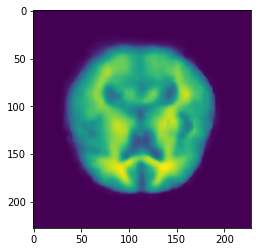

In [ ]:
plt.imshow(np.reshape(mean_test_res, (228,228)))

compared to a few random images:

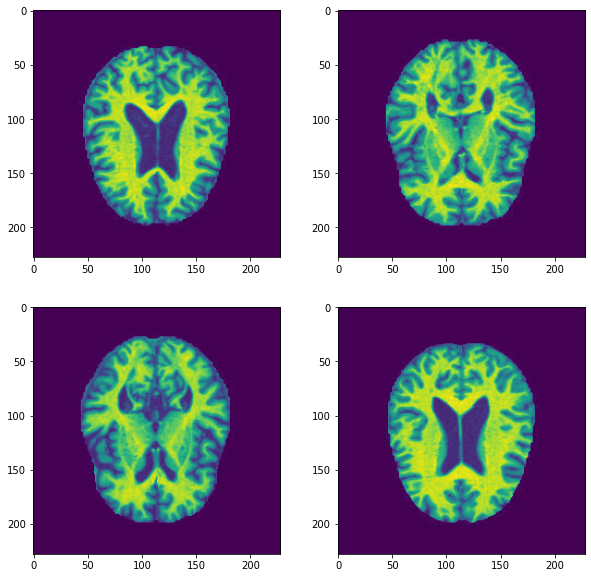

In [ ]:
fig = plt.figure(figsize = (10,10))
axs = fig.subplots(2,2)
axs[0][0].imshow(random.choice((imgs*255).astype('uint8')))
axs[0][1].imshow(random.choice((imgs*255).astype('uint8')))
axs[1][0].imshow(random.choice((imgs*255).astype('uint8')))
axs[1][1].imshow(random.choice((imgs*255).astype('uint8')))

Looks sane to us :)  
Interestingly, the image created from mean features looks much brighter than the result from the previous autoencoder and also from the actual MRIs. This could suggest that the whiteness is a result of the bias we added, and that the autoencoder deemed it more relevant for the classifying.

And now, we can regress - again!

In [ ]:
map = {'NonDemented': 1,'VeryMildDemented': 2, 'MildDemented': 3, 'ModerateDemented': 4}
reverse_map = {1: 'NonDemented',2: 'VeryMildDemented',3: 'MildDemented',4: 'ModerateDemented'}

In [ ]:
classes = pd.DataFrame(classes, columns=['classes'])

In [ ]:
def encode(dat):
  return map[dat]

classes['encoded'] = classes['classes'].apply(encode)

In [ ]:
normed_fetures = (features - features.mean())

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(normed_fetures, classes['encoded'])

In [ ]:
y_test

5426    2
382     1
3106    1
286     1
5683    3
       ..
3662    2
6108    3
5903    3
5709    3
1246    1
Name: encoded, Length: 1600, dtype: int64

In [ ]:
clf = LogisticRegression(max_iter=100000,class_weight="balanced").fit(x_train, y_train)
clf.score(x_test, y_test)

0.6225

The score seems better than the previous autoencoder, though still not as good as we hoped.

##Analizing the results

In [ ]:
predictions = clf.predict(features.values)
pred = pd.DataFrame(predictions)

def decode(dat):
  return reverse_map[dat]

classes['predicted'] = pred[0].apply(decode)

In [ ]:
classes['pred_encoded'] = predictions

In [ ]:
pd.DataFrame(sklearn.metrics.confusion_matrix(classes['encoded'], classes['pred_encoded'],normalize = 'true'))

0         1         2         3
0  0.876563  0.102500  0.019688  0.001250
1  0.612500  0.345982  0.037946  0.003571
2  0.348214  0.343750  0.306920  0.001116
3  0.000000  0.000000  0.000000  1.000000

the results look similer in shape to the first autoencoder - we get good classfications at the edges (no dementia and moderate dementia) and noise results in the middle.

Lets look at the most significant features:

Permutation explainer: 1601it [00:54, 23.59it/s]


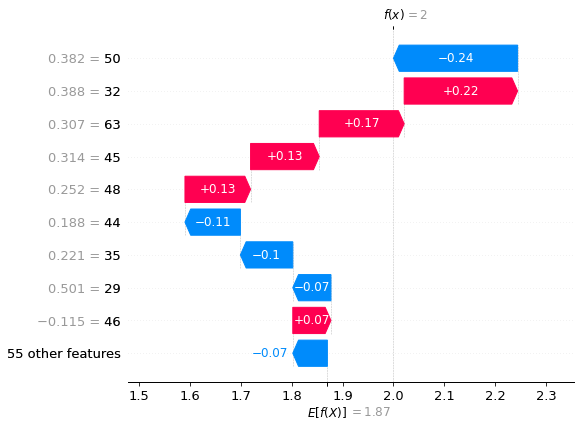

In [ ]:
expliner = shap.Explainer(clf.predict, x_test)
shap_v = expliner(x_test)
shap.plots.waterfall(shap_v[0])

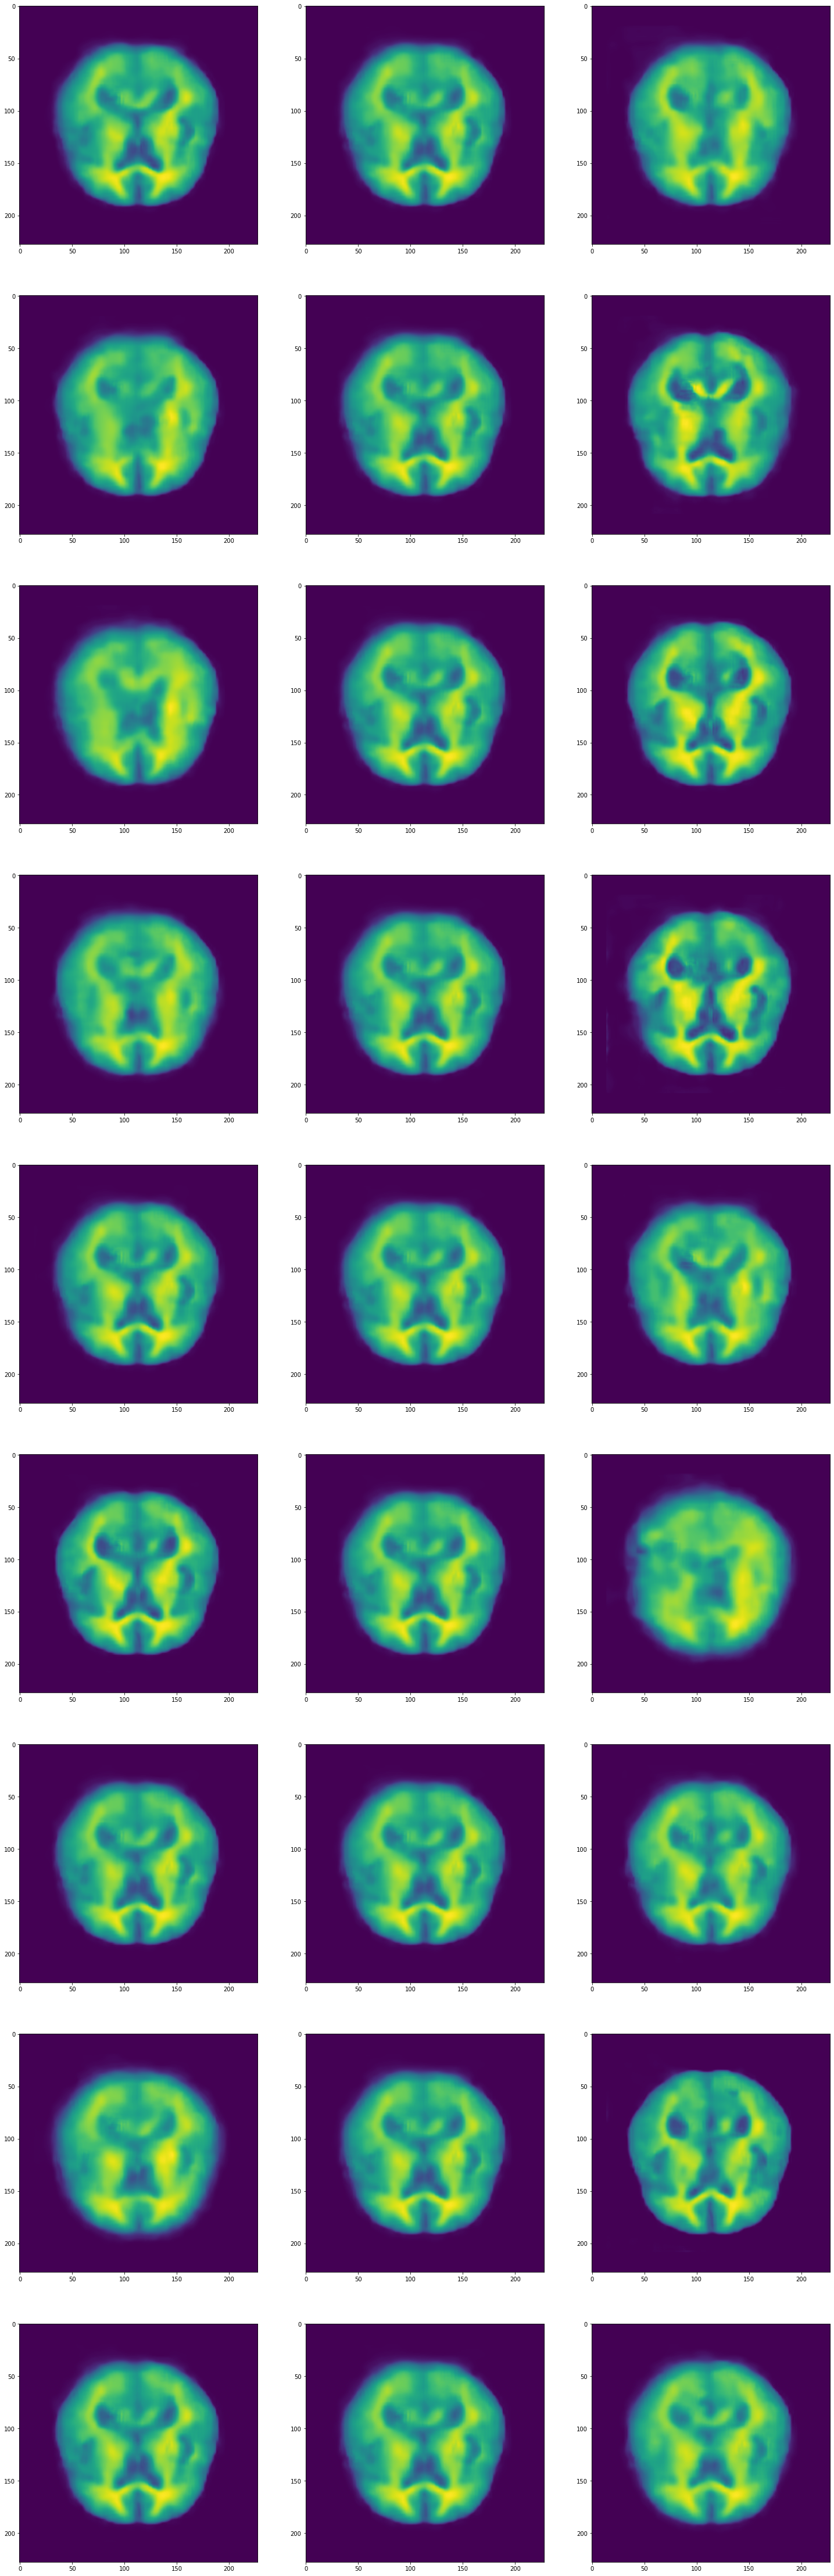

In [ ]:
mean_test = features.mean()

mean_test_res = decoder(np.reshape(mean_test.values,(1,64)))

features_to_print = ['50','32','63','45','48','44','35','29','46']

fig = plt.figure(figsize = (25,9*len(features_to_print)))
axs = fig.subplots(9,3)

ax = 0
for i in features_to_print:
  mean_test[i] = features[i].min()
  mean_test_res = decoder(np.reshape(mean_test.values,(1,64)))
  axs[ax][0].imshow(np.reshape(mean_test_res, (228,228)))
  
  mean_test[i] = features[i].median()
  mean_test_res = decoder(np.reshape(mean_test.values,(1,64)))
  axs[ax][1].imshow(np.reshape(mean_test_res, (228,228)))

  mean_test[i] = features[i].max()
  mean_test_res = decoder(np.reshape(mean_test.values,(1,64)))
  axs[ax][2].imshow(np.reshape(mean_test_res, (228,228)))

  mean_test[i] = features[i].mean()

  ax+=1
fig.show()

Its difficult to say, but we do get the feeling that this autoencoder foucuses more on grey matter. 

#Conclusion
In the EDA part of this project, we found some very significant differences between our augmented data, which we intended to use for training, and the original dataset. 
While working on this project. we've had the opportunity to use some very interesting tools, and gain insight to the way machine learning techniques apply to image data, and specifically to images with small color range and very intricate spacial patterns. We've seen how classic models that do not create internal computational models of these patterns have great success rates on training data, or data that is very similar to the training data (like the performance we saw from the logistic regressor while being trained on the original dataset - 96%), but then generalize poorly on data that is not in the "format" of the training.
We can even point to a pattern between model complexity and generalization - let's recap a bit of what we've seen. We'll give a brief reminder of some of these models together with a  
(% success on training data tests, % success on original data tests) type of map next to each one.  
First - the classic models:  
1. A per-pixel regressor, the simplest model with the most direct relation to the data (%75, %31). This model we've also trained directly on the original data, with a score of 96%.  
2. A regressor on HOGs of the data measuring gradients directly (68%, 28%)
3. A decision tree on low resolution images - this model is less direct than the regressor in two ways, using clusters of pixels, and entropy measurements to build itself (%59, %38).

 
Secondly - the deep models:  
4. A 64 dimension AutoEncoder network to compress our images, then a logistic regressor on the encoding ( -- , 62%)
5. Straightforward CNN, with a classifying goal: (80%, 64%) 

We can see that the more complicated the model is, the more we can expect it to generalize the learning to new data, with the obvious extreme differences showing most between deep models and classic ones.  
  
##Retrospective, and possible future steps  
(Or: what we would do with a billion $, a stable quantum computer and infinite time):  
The most apparent problem we faced was that the dataset we used (the augmented data) was not as much an accurate representation of the original MRIs as we hoped. The next step we would take, is to try and improve it's quality - the simple and first technique that comes to mind would simply be to try and stretch the augmented images horizontally, and orient them accross a symmetry line (which sounds simple, but probably is quite far from that). We could also try to augment the data ourselves, which would probably be even more complicated, but would allow us better control of the results.  
Since MRI images are usually under patient confidentiality, trying to collect a dataset of these directly would be extermely expensive and quite hard, so some method of data augmetation is probably necessary.  
We might also try to encorporate our insights from the EDA into the deep learning process, by pushing our networks to learn about gray matter degration, perhaps with similar techniques to the one we used in the second autoencoder, where we tried to influence our loss function to recognize dementia while improving the encoding capabalities.  
  
For a finishing note, we'd like to say that we found this problem quite interesting, and it took us in very different paths than what we originally expected. 